# Desafio Kaggle - UCI HEART DISEASES
# Daniel Malheiros

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clique para mostrar codigo."></form>''')

# Lendo Dataset, fazendo imports e primeiras impressões:

**Heart Disease Data Set:**

https://www.kaggle.com/ronitf/heart-disease-uci

https://www.kaggle.com/cherngs/heart-disease-cleveland-uci

https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# metricas e processamento
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import shap

# modelos
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


O dataset original possui 76 features, que foram reduzidas a um subset com apenas 14 para o desafio Kaggle (por diversos motivos como features inconsistentes e grande quantidade de dados faltantes). O objetivo principal do desafio é classificar pacientes como 0 (saudaveis) e 1 (com doença cardíaca).

Existem também diversos objetivos secundários, como limpeza dos dados, visualização e obtenção de insights e feature engineering. Nesse notebook, passaremos por todas estas etapas e tentaremos classificar corretamente nossa variável alvo usando modelos KNN, Random Forest, Regressão Logística, SVM e GBM.

Por fim, utilizaremos valores SHAP para interpretar as variáveis mais e menos influentes para cada modelo. 

A dificuldade de obter dados confiáveis é um problema recorrente. Utilizando os valores SHAP, treinaremos os mesmos modelos após remover suas três variáveis consideradas menos influentes e analisaremos seu rendimento. Se recebermos métricas iguais ou melhores nestes novos modelos em comparação com os primeiros, podemos defender que, no contexto do dataset de Cleveland, mais features não necessariamente trazem melhores resultados, teoricamente poupando a necessidade do hospital de obter e armazenar certos tipos de dado que não contribuem para o modelo.


In [3]:
# Lendo o dataset e traduzindo colunas:

columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
           'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']

df = pd.read_csv(r'C:\Users\Daniel O. Malheiros\Downloads\processed.cleveland.data', names=columns)


df = df.rename(columns={'age':'idade',
                  'sex':'sexo',
                  'cp':'dor toracica',
                  'trestbps':'pressão (repouso)',
                  'chol':'colesterol',
                  'fbs':'glicose em jejum',
                  'restecg':'ECG em repouso',
                  'thalach':'frequência cardíaca máxima (stress)',
                  'exang':'angina (stress)',
                  'oldpeak':'valor ST',
                  'slope':'curva ST',
                  'ca':'num vasos',
                  'thal':'defeito de perfusão',
                  'condition':'condicao'})

**Dataset:**

In [4]:
df.head()

,idade,sexo,dor toracica,pressão (repouso),colesterol,glicose em jejum,ECG em repouso,frequência cardíaca máxima (stress),angina (stress),valor ST,curva ST,num vasos,defeito de perfusão,condicao
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**Shape:**

In [5]:
df.shape

(303, 14)

**Colunas (features e variavel alvo):**

In [6]:
df.columns

Index(['idade', 'sexo', 'dor toracica', 'pressão (repouso)', 'colesterol',
       'glicose em jejum', 'ECG em repouso',
       'frequência cardíaca máxima (stress)', 'angina (stress)', 'valor ST',
       'curva ST', 'num vasos', 'defeito de perfusão', 'condicao'],
      dtype='object')

**info:**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   idade                                303 non-null    float64
 1   sexo                                 303 non-null    float64
 2   dor toracica                         303 non-null    float64
 3   pressão (repouso)                    303 non-null    float64
 4   colesterol                           303 non-null    float64
 5   glicose em jejum                     303 non-null    float64
 6   ECG em repouso                       303 non-null    float64
 7   frequência cardíaca máxima (stress)  303 non-null    float64
 8   angina (stress)                      303 non-null    float64
 9   valor ST                             303 non-null    float64
 10  curva ST                             303 non-null    float64
 11  num vasos                       

Nosso dataset possui 303 linhas, com 13 features e uma coluna representando a variável alvo (condição), somando 14. De cara podemos ver que algumas variáveis estão com o tipo de dado errado (por exemplo, condição deveria ser uma categoria, idade um integer, etc). Vamos ajustar isso.

# Ajustando variaveis e seus dtypes

Antes de começarmos, vamos dar uma arrumada em nosso dataset.

Alguns tipos de dados estão incorretos, enquanto outros estão pouco claros (categorias com números pouco representativos). Para mais informações sobre os dados originais e seus formatos, entre em https://archive.ics.uci.edu/ml/datasets/Heart+Disease




No dataset original, a variável alvo ('condicao') possui os valores 0, 1, 2, 3 e 4, sendo 0 ausência de doença e 1, 2, 3 e 4 presença de doença. 

O dataset não deixa claro a diferença entre os valores positivos para doença cardíaca (suponho que gravidade). Transformarei esses valores para trabalharmos com uma classificação binária, ou seja, somente 0 (ausência de doença cardíaca) e 1 (presença de doença cardíaca).

Lembrando que o proprio desafio Kaggle orienta esta mudança.


In [8]:
df['condicao'] = df['condicao'].replace({1:1, 2:1, 3:1, 4:1})
df['condicao'] = pd.Categorical(df['condicao'])

Transformando variável Idade em um int:

In [9]:
df['idade'] = df['idade'].astype('int')

Transformando variavel binaria de sexo em categorica com nomes "homem" e "mulher" para facilitar visualizações e entendimento do dataset:

0 = Mulher

1 = Homem


In [10]:
df['sexo'] = df['sexo'].replace({0:'mulher', 1:'homem'})
df['sexo'] = pd.Categorical(df['sexo'])

Transformando a variável "dor toracica" em categorica, explicitando nomes das categorias:

1 = Angina típica

2 = Angina Atípica

3 = Dor não-anginosa

4 = Assintomático




In [11]:
df['dor toracica'] = df['dor toracica'].replace({1:'angina tipica',
                           2:'angina atipica',
                           3:'dor não-anginal',
                           4:'assintomatico'})

df['dor toracica'] = pd.Categorical(df['dor toracica'])

Transformando variável "Glicose em jejum" em categórica, explicitando nomes das categorias:

0 = valor menor que 120mg/dl

1 = valor maior que 120mg/dl 


In [12]:
df['glicose em jejum'] = df['glicose em jejum'].replace({0:'menor que 120mg',1:'maior que 120mg'})

df['glicose em jejum'] = pd.Categorical(df['glicose em jejum'])

Transformando variável "ECG em repouso" em categórica. Aqui manterei os valores como números, pois é importante que haja a intuição que quanto maior o valor, mais grave o quadro (mais a frente, na sessão "Entendendo as variáveis", falo mais sobre):

0 = Normal

1 = Anormalidade no segmento ST ou onda T do eletrocardiograma

2 = Hipertrofia ventricular segundo critério de Estes



In [13]:
df['ECG em repouso'] = pd.Categorical(df['ECG em repouso'])

Transformando a variável "Angina (stress)" em categorica, explicitando nomes das categorias:

0 = Sem angina durante estresse

1 = Com angina durante estresse


In [14]:
df['angina (stress)'] = df['angina (stress)'].replace({0:'sem angina (stress)', 1: 'com angina (stress)'})

df['angina (stress)'] = pd.Categorical(df['angina (stress)'])

Transformando variável Curva ST em categorica,  explicitando nomes das categorias:

1 = curva crescente

2 = segmento reto

3 = curva decrescente


In [15]:
df['curva ST'] = df['curva ST'].replace({1:'ST crescente',
                       2:'ST reto',
                       3:'ST decrescente'})

df['curva ST'] = pd.Categorical(df['curva ST'])

Transformando a variável "Defeito de perfusão" em categórica, tratando o caracter especial "?", que está representando valor faltante e explicitando nomes das categorias:

3 = Sem presença

6 = Defeitos fixos

7 = Defeitos reversíveis

? = Missing Value





In [16]:
df['defeito de perfusão'] = df['defeito de perfusão'].replace('?',np.nan)

df['defeito de perfusão'] = pd.to_numeric(df['defeito de perfusão'])
df['defeito de perfusão'] = df['defeito de perfusão'].replace({3:'sem defeito', 6:'defeito fixo', 7:'defeixo reversivel'})

df['defeito de perfusão'] = pd.Categorical(df['defeito de perfusão'])

A variável "num vasos" também possui o carácter "?" representando valores faltantes, vamos ajustar:

(manterei essa variável como numerica por enquanto, explicarei mais a frente)




In [17]:
df['num vasos'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [18]:
df['num vasos'] = df['num vasos'].replace('?',np.nan)
df['num vasos'] = pd.to_numeric(df['num vasos'])

df['num vasos'].unique()

array([ 0.,  3.,  2.,  1., nan])

Vamos dar uma olhada:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   idade                                303 non-null    int32   
 1   sexo                                 303 non-null    category
 2   dor toracica                         303 non-null    category
 3   pressão (repouso)                    303 non-null    float64 
 4   colesterol                           303 non-null    float64 
 5   glicose em jejum                     303 non-null    category
 6   ECG em repouso                       303 non-null    category
 7   frequência cardíaca máxima (stress)  303 non-null    float64 
 8   angina (stress)                      303 non-null    category
 9   valor ST                             303 non-null    float64 
 10  curva ST                             303 non-null    category
 11  num vasos          

Pronto! Nossas variáveis estão prontas para darmos continuidade ao projeto.

# Identificando valores faltantes e duplicatas:

Mapa de valores faltantes:

<AxesSubplot:>

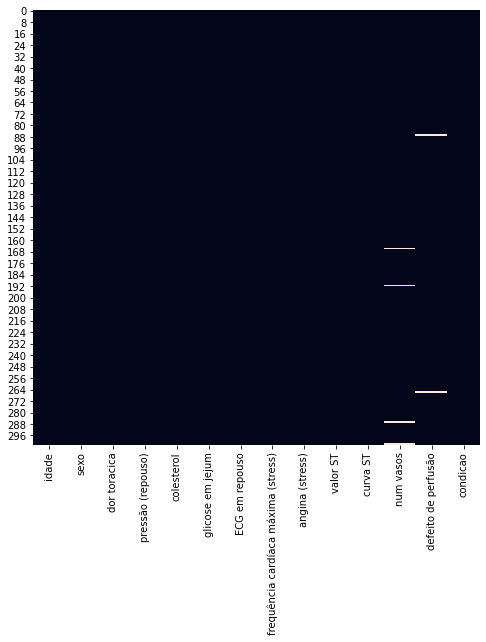

In [20]:
plt.figure(figsize=(8,8))
sns.heatmap(df.isnull(), cbar=False)

In [21]:
df.isnull().sum()

idade                                  0
sexo                                   0
dor toracica                           0
pressão (repouso)                      0
colesterol                             0
glicose em jejum                       0
ECG em repouso                         0
frequência cardíaca máxima (stress)    0
angina (stress)                        0
valor ST                               0
curva ST                               0
num vasos                              4
defeito de perfusão                    2
condicao                               0
dtype: int64

Aparentemente temos 6 valores faltantes em nosso dataframe, 4 na coluna "num vasos" e 2 na coluna "defeito de perfusão". As linhas com valores faltantes são:

In [22]:
df[df['num vasos'].isnull() == True]

,idade,sexo,dor toracica,pressão (repouso),colesterol,glicose em jejum,ECG em repouso,frequência cardíaca máxima (stress),angina (stress),valor ST,curva ST,num vasos,defeito de perfusão,condicao
166,52,homem,dor não-anginal,138.0,223.0,menor que 120mg,0.0,169.0,sem angina (stress),0.0,ST crescente,NaN,sem defeito,0
192,43,homem,assintomatico,132.0,247.0,maior que 120mg,2.0,143.0,com angina (stress),0.1,ST reto,NaN,defeixo reversivel,1
287,58,homem,angina atipica,125.0,220.0,menor que 120mg,0.0,144.0,sem angina (stress),0.4,ST reto,NaN,defeixo reversivel,0
302,38,homem,dor não-anginal,138.0,175.0,menor que 120mg,0.0,173.0,sem angina (stress),0.0,ST crescente,NaN,sem defeito,0


In [23]:
df[df['defeito de perfusão'].isnull() == True]

,idade,sexo,dor toracica,pressão (repouso),colesterol,glicose em jejum,ECG em repouso,frequência cardíaca máxima (stress),angina (stress),valor ST,curva ST,num vasos,defeito de perfusão,condicao
87,53,mulher,dor não-anginal,128.0,216.0,menor que 120mg,2.0,115.0,sem angina (stress),0.0,ST crescente,0.0,NaN,0
266,52,homem,assintomatico,128.0,204.0,maior que 120mg,0.0,156.0,com angina (stress),1.0,ST reto,0.0,NaN,1


Com essa checagem, percebemos que todos os valores faltantes estão em linhas diferentes uns dos outros, logo, linhas com valores faltantes são:

87, 166, 192, 266, 287 e 303 (6 linhas)

In [24]:
print('Linhas com valores faltantes (%) / Total de linhas no DF: ' + str(round(6 * 100 / len(df),4)) + '%')

Linhas com valores faltantes (%) / Total de linhas no DF: 1.9802%


Com este cálculo, sabemos que estas linhas representam somente 1,98% de nosso dataframe. Como é um valor baixo, vou optar dropar estes valores em vez de tentar preenchê-los.



Novo shape:

In [25]:
df = df.dropna()
df.shape

(297, 14)

Checando duplicatas:

In [26]:
# Checando duplicatas
len(df[df.duplicated() == True])

0

Possuímos 0 duplicatas em nosso dataframe. Que bom!



Checando correlações de variáveis contínuas:

<AxesSubplot:>

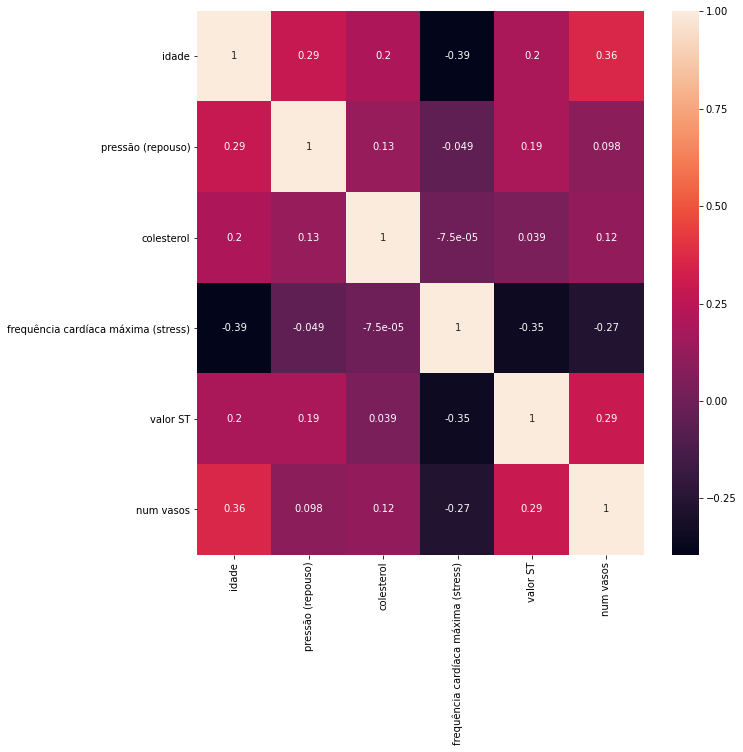

In [27]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

Podemos ver  com este heatmap que nossas variáveis de valor contínuo não possuem correlações muito altas (positivas ou negativas) entre si, o que é ótimo!  Isso nos salva de um possível problema de multicolinearidade que poderia atrapalhar nosso modelo.


# Procurando por Outliers

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
idade,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
pressão (repouso),297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
colesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
frequência cardíaca máxima (stress),297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
valor ST,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2
num vasos,297.0,0.676768,0.938965,0.0,0.0,0.0,1.0,3.0



Vamos checar se existem outliers em nossas variáveis com valores contínuos (idade, pressão (repouso), colesterol, frequência cardíaca máxima (stress), valor ST). Não incluirei a coluna 'num vasos' pois mesmo a tendo mantido como numérica, sabemos que nela só possuímos os valores 0, 1, 2 e 3.

Existem diversas formas de procurar outliers. Vamos utilizar os boxplots (IQR) para investigar.




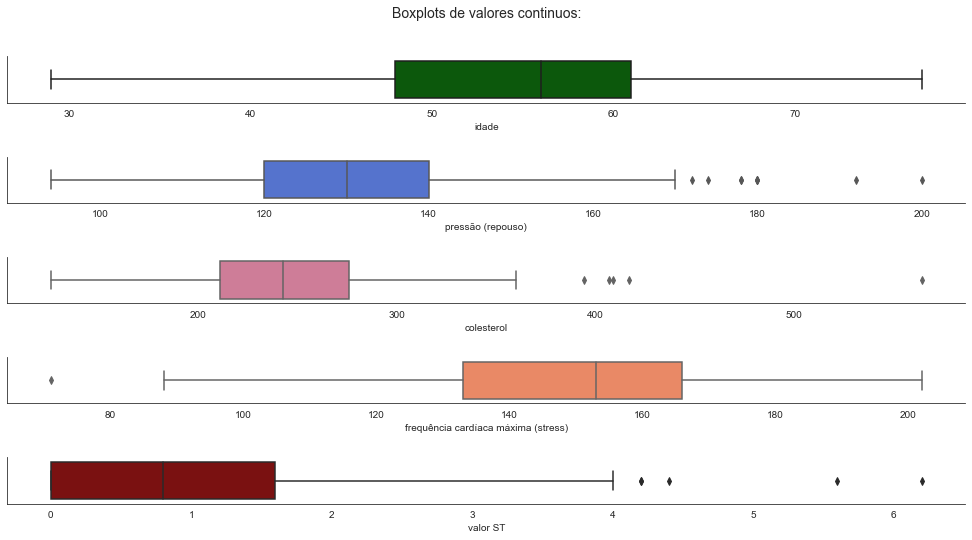

In [29]:
sns.set_style('white')

fig, ax = plt.subplots(5,1, figsize=(14,8))

ax[0].set_title('Boxplots de valores continuos:\n\n', fontsize=14)

sns.boxplot(x='idade', data=df, ax=ax[0], color='darkgreen')
sns.boxplot(x='pressão (repouso)', data=df, ax=ax[1], color='royalblue')
sns.boxplot(x='colesterol', data=df, ax=ax[2], color='palevioletred')
sns.boxplot(x='frequência cardíaca máxima (stress)', data=df, ax=ax[3], color='coral')
sns.boxplot(x='valor ST', data=df, ax=ax[4], color='darkred')



plt.tight_layout(pad=2.5)
sns.despine()
plt.show()

Podemos perceber alguns outliers em todas as colunas contínuas exceto Idade. 

Utilizando o metodo IQR, consideramos valores abaixo de Q1 - 1.5 x IQR e acima de Q3 - 1.5 x IQR como outliers.
Vamos encontra-los no dataframe.

(Q1 = primeiro quartil, Q3 = terceiro quartil, IQR = intervalo interquartil)

Vamos utilizar a função abaixo (clique em "ver codigo" no inicio do notebook), para facilitar nossos cálculos:



In [30]:
# função para identificar e remover outliers com mais facilidade

def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentil
        Q3 = np.percentile(feature_data, 75.) # 75th percentil
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5
        outliers = feature_data.loc[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        if not drop:
            print('Coluna: {}\nNo de Outliers: {}\nIndex: {}\n'.format(each_feature, len(outliers), outliers))
        if drop:
            df.drop(outliers, inplace = True, errors = 'ignore')
            print('Coluna: {}\nOutliers removidos\n'.format(each_feature))

In [31]:
df_outliers = df[['pressão (repouso)', 'colesterol', 'frequência cardíaca máxima (stress)', 'valor ST']]

Outliers:

In [32]:
outliers(df_outliers)

Coluna: pressão (repouso)
No de Outliers: 9
Index: [14, 83, 126, 172, 183, 188, 201, 213, 231]

Coluna: colesterol
No de Outliers: 5
Index: [48, 121, 152, 173, 181]

Coluna: frequência cardíaca máxima (stress)
No de Outliers: 1
Index: [245]

Coluna: valor ST
No de Outliers: 5
Index: [91, 123, 183, 191, 285]



Ok! Identificados os valores e seus respectivos índices no dataframe, podemos finalmente removê-los para ter resultados estatisticamente mais significantes.

Shape pré-remoção:

In [33]:
df.shape

(297, 14)

In [34]:
outliers(df_outliers, drop=True)

Coluna: pressão (repouso)
Outliers removidos

Coluna: colesterol
Outliers removidos

Coluna: frequência cardíaca máxima (stress)
Outliers removidos

Coluna: valor ST
Outliers removidos



Shape pós-remoção:

In [35]:
df.shape

(278, 14)

# Entendendo as variáveis com EDA

In [36]:
# Função utilizada para apresentar valores em graficos de barra

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

**Condiçao (condition)**

Nossa variável alvo, ou seja, presença ou não de doença cardíaca. 

0 = Sem doença cardíaca

1 = Com doença cardíaca




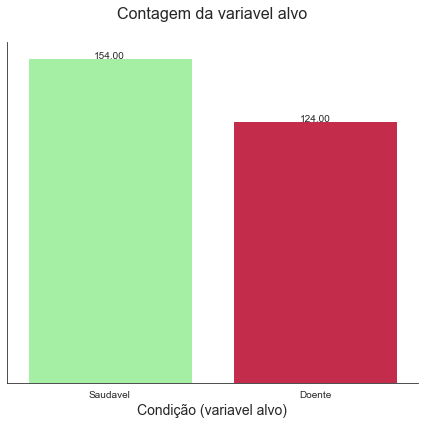

In [37]:
sns.set_style('white')
plt.figure(figsize=(6,6))

colors = ['palegreen','crimson']
ax = sns.countplot(df['condicao'], palette=colors)
show_values_on_bars(ax)

plt.ylabel('')
plt.yticks(ticks=[])
plt.xticks(ticks=[0,1],labels=['Saudavel','Doente'])
plt.xlabel('Condição (variavel alvo)', fontdict={'size':14})
plt.title('Contagem da variavel alvo\n', fontdict={'size':16})


sns.despine()
plt.tight_layout()
plt.show()

Nossas variáveis alvo estão relativamente balanceadas, com 154 pacientes 0 (sem doença) e 124 pacientes 1 (com doença).

**Sexo (sex):**

Sexo do paciente


Em média, homens sofrem seu primeiro ataque cardíaco aos 65 anos, enquanto a média de idade para mulheres é em torno de 72. Homens tendem a apresentar risco aumentado para doenças cardiovasculares se comparado às mulheres. Fatores comportamentais, biológicos e sociais podem estar por trás dessa diferença. 

Fontes:

https://www.hopkinsmedicine.org/health/wellness-and-prevention/special-heart-risks-for-men

https://www.health.harvard.edu/heart-health/the-heart-attack-gender-gap



Vamos contar quantos pacientes saudaveis e doentes temos para cada sexo:

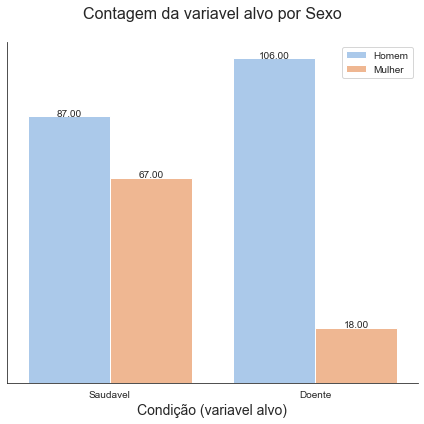

In [38]:
sns.set_style('white')
plt.figure(figsize=(6,6))

ax = sns.countplot('condicao',hue='sexo',data=df, palette='pastel')
show_values_on_bars(ax)

plt.ylabel('')
plt.xlabel('Condição (variavel alvo)', fontdict={'size':14})
plt.title('Contagem da variavel alvo por Sexo\n', fontdict={'size':16})
plt.yticks(ticks=[])
plt.xticks(ticks=[0,1],labels=['Saudavel','Doente'])
plt.legend(['Homem','Mulher'])
sns.despine()
plt.tight_layout()
plt.show()

Na condição Saudavel (0), os valores entre sexos são relativamente balanceados, porem na condição Doente (1), temos muito mais homens do que mulheres, o que significa que a variavel sexo (especificamente: ser homem) é um de fato fator de risco para doenças cardiacas (corroborando com a literatura medica).

Importante notar que nosso dataset possui aproximadamente o dobro de pacientes homens que mulheres.


In [39]:
df['sexo'].value_counts()

homem     193
mulher     85
Name: sexo, dtype: int64

**Idade (age):**

Idade do paciente em anos.

Com o avanço dos anos, o sistema cardiovascular passa por uma série de alterações, tais como arteriosclerose (endurecimento, perda de elasticidade e espessamento progressivo das paredes das artérias), diminuição da distensibilidade da aorta e das grandes artérias, comprometimento da condução cardíaca e redução na função barorreceptora (regulação de pressão cardíaca).

A correlação entre idade avançada e risco de doenças cardiovasculares já é bem conhecida pela literatura médica, porém, diversos fatores como estilo de vida, comorbidades e histórico familiar podem influenciar esta correlação. Infelizmente não possuímos todos estes dados neste dataset.

Fonte:

https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0066-782X2002001500011&lng=pt&nrm=iso&tlng=pt




Vamos checar a distribuição da idade do dataset, tanto para pacientes saudáveis e pacientes com doenças cardíacas.



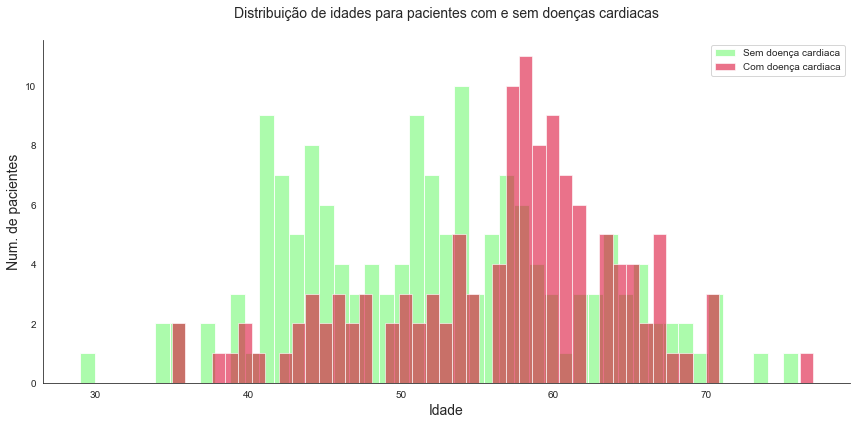

In [40]:
sns.set_style('white')
plt.figure(figsize=(12,6))

sns.distplot(df[df['condicao'] == 0]['idade'], kde=False, bins=48, color='palegreen', hist_kws=dict(alpha=.8),label="Sem doença cardiaca")
sns.distplot(df[df['condicao'] == 1]['idade'], kde=False, bins=48, color='crimson', hist_kws=dict(alpha=.6),label="Com doença cardiaca")



plt.xlabel('Idade', fontdict={'size':14})
plt.ylabel('Num. de pacientes', fontdict={'size':14})

plt.title('Distribuição de idades para pacientes com e sem doenças cardiacas\n', fontdict={'size':14})
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

Encontramos pacientes saudáveis e doentes bem distruibuidos entre as idades do dataframe. E possível notar que a maior parte dos casos positivos estão entre 55 e 62 anos, aproximadamente.



In [41]:
print(f"Mediana de idade para pacientes doentes: {df[df['condicao'] == 1]['idade'].median()}")
print(f"Mediana de idade para pacientes saudáveis: {df[df['condicao'] == 0]['idade'].median()}")

Mediana de idade para pacientes doentes: 58.0
Mediana de idade para pacientes saudáveis: 52.0


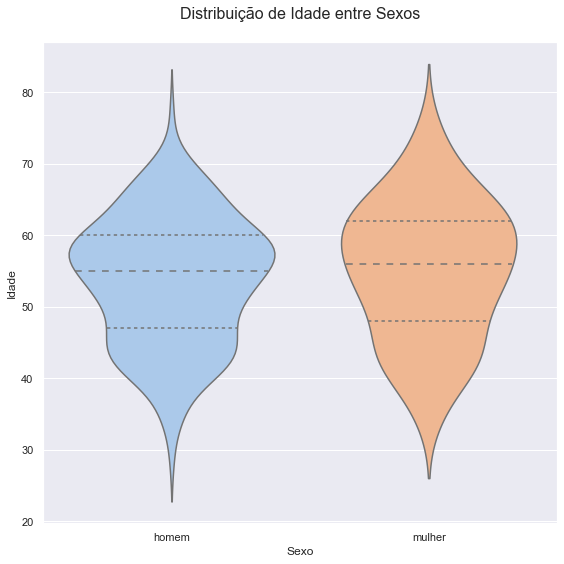

In [42]:
sns.set()
plt.figure(figsize=(8,8))

sns.violinplot(x='sexo', y='idade', data=df, split=True, inner="quartile", palette='pastel')

plt.title('Distribuição de Idade entre Sexos\n', fontdict={'size':16})

plt.xlabel('Sexo',fontdict={'size':12})
plt.ylabel('Idade',fontdict={'size':12})
plt.tight_layout()

plt.show()

A distribuição de idades entre sexos parece ser parecida entre homens e mulheres, com a mediana por volta de 55 anos.

In [43]:
print(f"Mediana de idade (mulheres): {df[df['sexo'] == 'mulher']['idade'].median()}")
      
print(f"Mediana de idade (homens): {df[df['sexo'] == 'homem']['idade'].median()}")

Mediana de idade (mulheres): 56.0
Mediana de idade (homens): 55.0


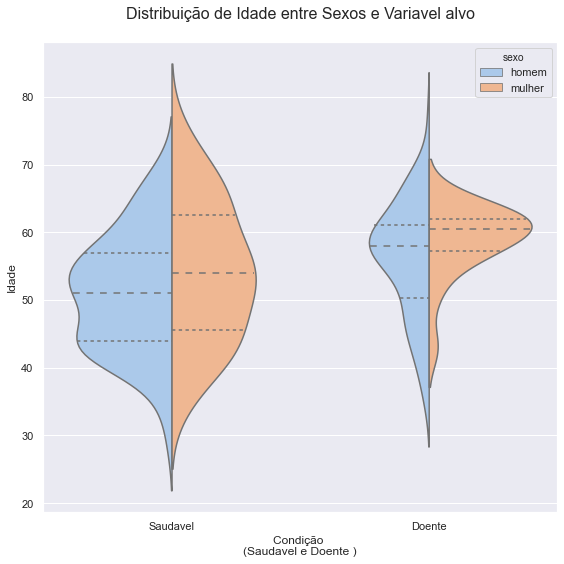

In [44]:
sns.set()
plt.figure(figsize=(8,8))

sns.violinplot(x='condicao',y='idade', hue='sexo', data=df, split=True, inner="quartile", palette='pastel')

plt.title('Distribuição de Idade entre Sexos e Variavel alvo\n', fontdict={'size':16})
plt.xlabel('Condição \n(Saudavel e Doente )', fontdict={'size':12})
plt.ylabel('Idade', fontdict={'size':12})
plt.xticks(ticks=[0,1],labels=['Saudavel','Doente'])

plt.tight_layout()

plt.show()

In [45]:
print(f"Mediana de idade (mulheres doentes): {df[(df['condicao'] == 1) & (df['sexo'] == 'mulher')]['idade'].median()}")
print(f"Mediana de idade (mulheres saudaveis): {df[(df['condicao'] == 0) & (df['sexo'] == 'mulher')]['idade'].median()}\n")
      
print(f"Mediana de idade (homens doentes): {df[(df['condicao'] == 1) & (df['sexo'] == 'homem')]['idade'].median()}")
print(f"Mediana de idade (homens saudaveis): {df[(df['condicao'] == 0) & (df['sexo'] == 'homem')]['idade'].median()}\n")

Mediana de idade (mulheres doentes): 60.5
Mediana de idade (mulheres saudaveis): 54.0

Mediana de idade (homens doentes): 58.0
Mediana de idade (homens saudaveis): 51.0



Podemos notar que mulheres tendem a ficar doentes mais velhas que homens. Essa informação corrobora com o que é descrito pela literatura médica. 

**Dor Toracica (cp: chest pain type):**

Tipo de angina, se presente, nas categorias:

Angina típica

Angina Atípica

Dor não-anginal

Assintomático

Angina pectoris é a descrição utilizada para caracterizar a dor torácica causada pela falta de sangue (isquemia) que acomete o músculo cardíaco. A angina se manifesta como uma sensação de dor ou desconforto no centro do peito, de localização mal definida, mais comumente descrita como aperto, peso, sufocação, queimação ou estrangulamento. É importante notar que angina não é uma doença e sim um sintoma.

A classificação de angina é normalmente feita via anamnese (entrevista com paciente) em repouso, logo, espera-se que haja ruído dos dados.

Angina típica:

Presença dos três fatores abaixo:

a) Desconforto ou dor retroesternal

b) Piora com esforço e/ou estresse emocional

c) Alivia com repouso e/ou uso de nitroglicerina

Angina Atípica: Trata-se de angina atípica quando paciente apresenta somente dois dos três fatores citados acima.

Dor não-anginal: Dor de localização muito bem definida (apontada com a ponta de um dedo) ou de duração fugaz (alguns segundos apenas).

Assintomático: Sem presença de angina, o que não necessariamente significa ausência de patologia. 

Fontes:

https://www.einstein.br/especialidades/cardiologia/doencas-sintomas/angina

https://www.heart.org/en/health-topics/heart-attack/angina-chest-pain

https://www.pfizer.com.br/sua-saude/coracao/angina



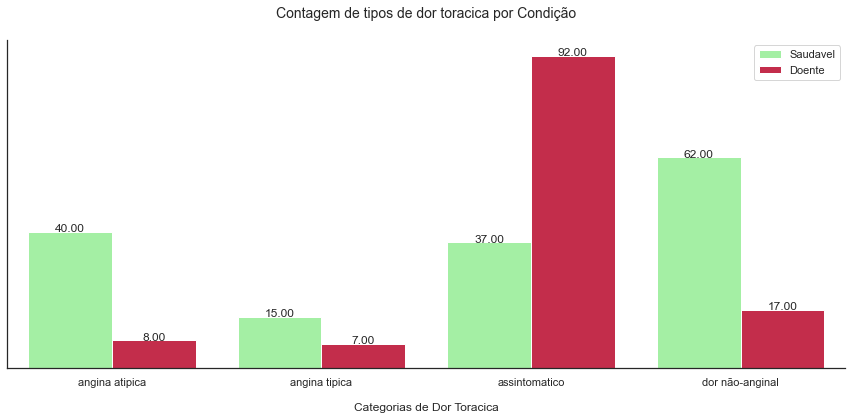

In [46]:
sns.set_style('white')
plt.figure(figsize=(12,6))

ax = sns.countplot(df['dor toracica'], hue=df['condicao'], palette=colors)
show_values_on_bars(ax)

plt.title('Contagem de tipos de dor toracica por Condição\n', fontdict={'size':14})
plt.xlabel('\nCategorias de Dor Toracica', fontdict={'size':12})
plt.ylabel('')
plt.yticks(ticks=[])
plt.legend(['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

Os dados acima são um pouco mais complicados.

Angina típica é a presença dos 3 fatores: desconforto ou dor retroesternal, piora com esforço e/ou estresse emocional e alivia com repouso e/ou uso de nitroglicerina. Já a angina atípica é a presença de somente dois destes. Logo, é natural que a diferença entre a quantidade de pacientes sem doença e com doença seja mais alta em pacientes que apresentam angina atípica (pois trata-se simplesmente de um menor acúmulo de sintomas que a angina típica). O mesmo pode ser dito para pacientes que apresentaram dor não-anginal, pois trata-se de um sintoma não específico para doenças cardíacas.

Logo, analisando os números:

Aprox. 16.6% dos pacientes que apresentaram angina atípica possuem doenças cardíacas

Aprox. 31.8% dos pacientes que apresentaram angina típica possuem doenças cardíacas

Aprox. 21.5% dos pacientes que apresentaram dor não anginal possuem doenças cardíacas


Existem aqui duas surpresas: a relação alta entre pacientes com doenças cardíacas assintomáticos e a quantidade de pacientes com sintomas que NÃO apresentaram doenças cardíacas.

É sempre complexo diagnosticar uma doença somente com a análise de um sintoma (neste caso, dor torácica). Temos poucas informações de como estes dados foram adquiridos e tendo em vista que são sintomas obtidos (geralmente) via anamnese, é necessário considerar a omissão (ou exagero) de informações por parte do paciente, resultando em falsos positivos e falsos negativos.

Apesar de surpreendente, é importante notar que há uma literatura extensa sobre análise de doenças cardíacas em pacientes previamente assintomáticos (principalmente em idosos e diabéticos). 

(https://www.ncbi.nlm.nih.gov/books/NBK63673/)





**Pressão em repouso (trestbps):**

Pressão sanguínea arterial do paciente (mmHg) medida na chegada do paciente ao hospital.


Pressão alta pode ser um bom indicativo de doenças cardíacas. O valor considerado saudável varia muito entre do nascimento até os 18 anos, mas sendo rara a presença de doenças cardíacas nesta faixa etária e levando em conta que o paciente mais novo do dataset possui 29 anos, utilizarei como referência a tabela de classificação para pacientes 18+.


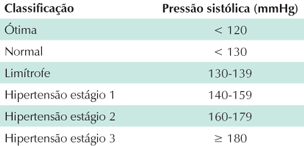

Fontes:

http://departamentos.cardiol.br/dha/consenso3/capitulo1.asp

https://doi.org/10.1590/S0066-782X2007001500012 

Com essa tabela, podemos adicionar uma coluna classificatória para os valores de pressão arterial. 

Faremos isso com o loop abaixo:




**Class pressão**

In [47]:
df['class pressão'] = ''

for idx, _ in df.iterrows():
    if df.loc[idx, 'pressão (repouso)'] < 120:
        df.loc[idx,'class pressão'] = 'otima'
    elif df.loc[idx, 'pressão (repouso)'] < 130:
        df.loc[idx,'class pressão'] = 'normal'
    elif 130 <= df['pressão (repouso)'][idx] <= 139:
        df.loc[idx,'class pressão'] = 'limitrofe'
    elif 140 <= df['pressão (repouso)'][idx] <= 159:
        df.loc[idx,'class pressão'] = 'hipertensao 1'
    elif 160 <= df['pressão (repouso)'][idx] <= 179:
        df.loc[idx,'class pressão'] = 'hipertensao 2'
    elif df['pressão (repouso)'][idx] >= 180:
        df.loc[idx,'class pressão'] = 'hipertensao 3'


Criando coluna com classificações de pressão:

In [48]:
df['class pressão'] = pd.Categorical(df['class pressão'])
print(df['class pressão'].unique())

['hipertensao 1', 'hipertensao 2', 'normal', 'limitrofe', 'otima']
Categories (5, object): ['hipertensao 1', 'hipertensao 2', 'normal', 'limitrofe', 'otima']


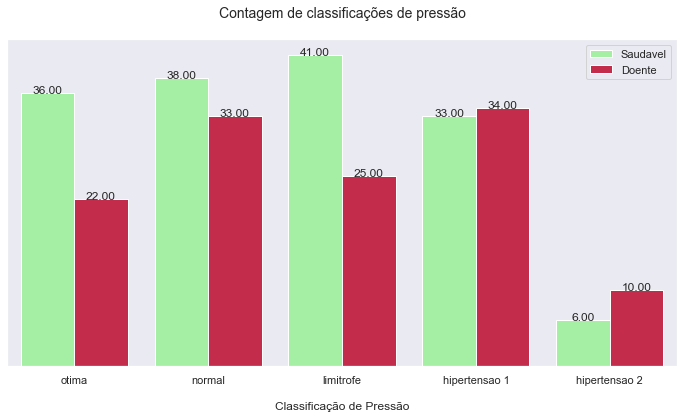

In [49]:
sns.set()
plt.figure(figsize=(12,6))

ax = sns.countplot(df['class pressão'],hue=df['condicao'],
                   order=['otima','normal','limitrofe','hipertensao 1','hipertensao 2'],
                   palette=colors)

show_values_on_bars(ax)

plt.ylabel('')
plt.xlabel('\nClassificação de Pressão')
plt.title('Contagem de classificações de pressão\n', fontdict={'size':14})
plt.yticks(ticks=[])
plt.legend(['Saudavel','Doente'])

plt.show()

O resultado deste gráfico corrobora parcialmente com o que esperávamos:

As barras de pressão ótima, normal e limítrofe possuem mais pacientes saudáveis do que doentes, enquanto as barras de hipertensão possuem mais pacientes doentes que saudáveis, apesar da diferença na barra "hipertensão 1" ser ínfima. O "problema" é que a maioria das classificações possuem pouca diferença entre os grupos saudáveis e doentes e as que possuem diferenças significativas nos trazem informações estranhas, por exemplo, a diferença entre saudáveis e não-saudáveis é maior em pacientes com pressão limítrofe do que saudável.

Os dados contínuos de pressão são capazes de nos dar insights mais precisos. Vamos dar uma olhada.




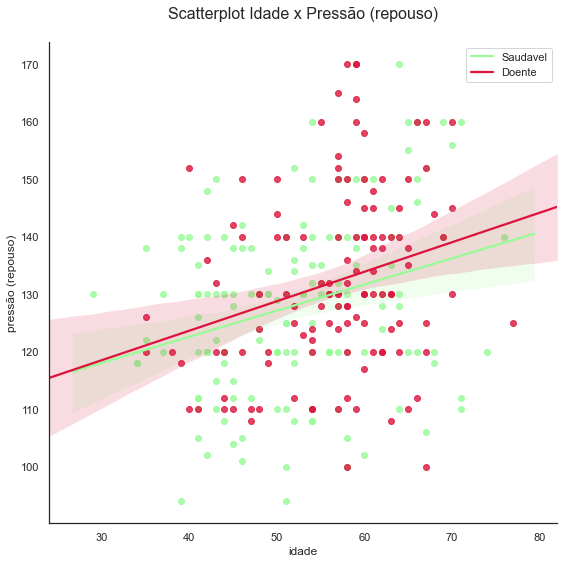

In [50]:
sns.set_style('white')

sns.lmplot(x='idade',y='pressão (repouso)', data=df, hue='condicao', height=8, legend=False, palette=colors)

plt.title('Scatterplot Idade x Pressão (repouso)\n', fontdict={'size':16})


plt.legend(['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

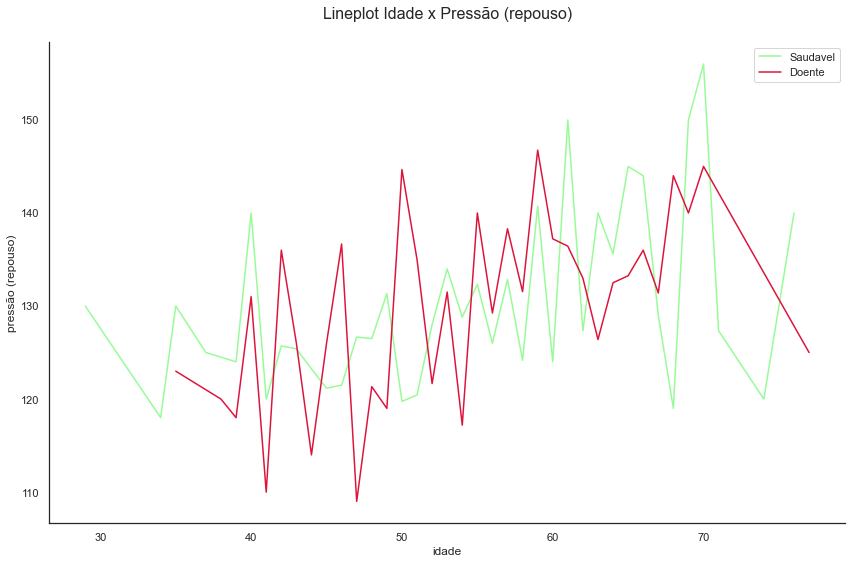

In [51]:
sns.set_style('white')
plt.figure(figsize=(12,8))
sns.lineplot(x='idade',y='pressão (repouso)', data=df, hue='condicao', palette=colors, ci=None)
plt.title('Lineplot Idade x Pressão (repouso)\n', fontdict={'size':16})

plt.legend(['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

In [52]:
print(f"Correlação entre Pressão (repouso) e Idade: {round(df['pressão (repouso)'].corr(df['idade']),3)}")

Correlação entre Pressão (repouso) e Idade: 0.292


Com estes gráficos, podemos ver que existe uma correlação (apesar de baixa, 0.292) entre idade e pressão. Também descobrimos aqui que aparentemente não há tendência clara entre pressão e doença cardíaca (nos nossos dados), visto que no scatterplot encontramos pacientes positivos bem distribuídos entre todos os valores de pressão. Vamos investigar mais.

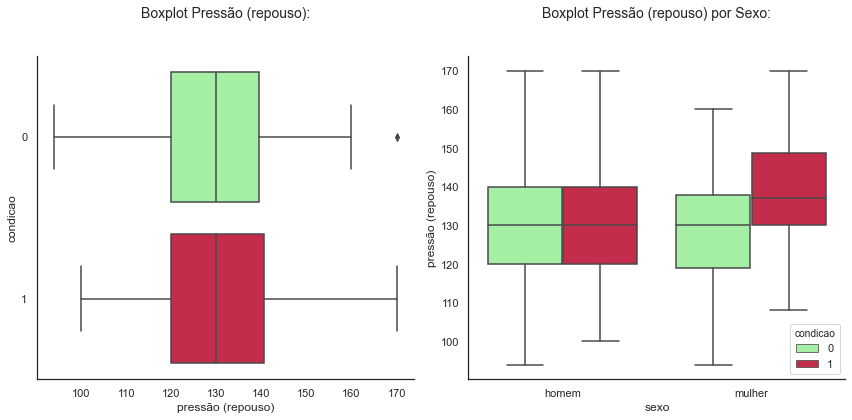

In [53]:
sns.set_style('white')
fig, ax = plt.subplots(1,2, figsize=(12,6))


sns.boxplot(y='condicao',x='pressão (repouso)', data=df, ax=ax[0], orient='h', palette=colors)
sns.boxplot(x='sexo', y='pressão (repouso)', hue='condicao', data=df, palette=colors, ax=ax[1])

ax[0].set_title('Boxplot Pressão (repouso):\n\n', fontsize=14)
ax[1].set_title('Boxplot Pressão (repouso) por Sexo:\n\n', fontsize=14)


sns.despine()
plt.tight_layout()
plt.show()

Confirmando nossa suspeita, o primeiro boxplot nos mostra que praticamente não há diferença entre as pressões em repouso para pacientes com e sem doenças cardiacas. Ao dividirmos este dado por sexo, percebemos que a unica diferença aparente são para pacientes mulheres positivas para doenças cardiacas (que apresentam pressão relativamente mais alta que os outros grupos). Logo, podemos considerar que pressão (repouso) elevada pode ser um bom indicador de doenças cardiacas para mulheres.

**Colesterol (chol)**

Nível de colesterol "total" do paciente em mg/dl. Infelizmente o dataset não faz uma diferenciação entre LDL (lipoproteína de baixa densidade, o colesterol "ruim"), HDL (lipoproteína de alta densidade, o colesterol "bom") e VLDL (lipoproteína de densidade muito baixa, partículas que eventualmente se tornam LDL). Altos níveis de LDL estão correlacionados a formação de Placas de Ateroma, trombos e doenças cardíacas enquanto altos níveis de HDL, por outro lado, podem ser relacionados a atividades anti-trombóticas, anti-oxidantes e anti-inflamatórias. 

O valor de referência desejável para o colesterol total é abaixo de 190 mg/dL.

Fontes:

https://saude.abril.com.br/medicina/o-que-e-o-colesterol-ldl-e-o-hdl/

http://hermespardini.com.br/blog/?p=76

https://saude.estadao.com.br/noticias/geral,cardiologistas-brasileiros-estabelecem-valores-mais-rigidos-de-colesterol-ruim,70001933579

Com isso, também podemos criar uma coluna classificatória de colesterol alto ou normal/baixo para ajudar na análise exploratória de dados de nosso dataset.




**Class colesterol**

In [54]:
df['class colesterol'] = 'classificação de colesterol'

for idx, _ in df.iterrows():
    if df.loc[idx, 'colesterol'] < 190:
        df.loc[idx,'class colesterol'] = 'normal/baixo'
    elif df.loc[idx, 'colesterol'] >= 190:
        df.loc[idx,'class colesterol'] = 'alto'
        
df['class colesterol'] = pd.Categorical(df['class colesterol'])
df['class colesterol'].unique()

['alto', 'normal/baixo']
Categories (2, object): ['alto', 'normal/baixo']

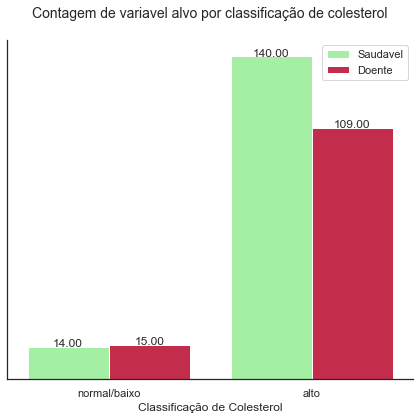

In [55]:
sns.set_style('white')
plt.figure(figsize=(6,6))

ax = sns.countplot('class colesterol', hue='condicao', data=df,
                   palette=colors,
                   order=['normal/baixo','alto'])

show_values_on_bars(ax)

plt.title('Contagem de variavel alvo por classificação de colesterol\n', fontdict={'size':14})
plt.yticks(ticks=[])
plt.ylabel('')
plt.legend(['Saudavel','Doente'])
plt.xlabel('Classificação de Colesterol')
sns.despine()
plt.tight_layout()
plt.show()

In [56]:
print(f"Pacientes com colesterol normal/baixo: {len(df[df['class colesterol'] == 'normal/baixo'])}")

Pacientes com colesterol normal/baixo: 29


In [57]:
print(f"Pacientes com colesterol alto: {len(df[df['class colesterol'] == 'alto'])}")

Pacientes com colesterol alto: 249


Com a contagem de pacientes por classificação de colesterol, podemos ver que a maior parte de nossos pacientes possui colesterol alto independente de ter ou não doença cardíaca. Já a contagem de pacientes com colesterol normal/baixo é praticamente igual para saudáveis e doentes. Esperávamos que colesterol fosse ser um bom indicador de doenças cardíacas, mas talvez não seja o caso neste dataset. Vamos nos aprofundar:



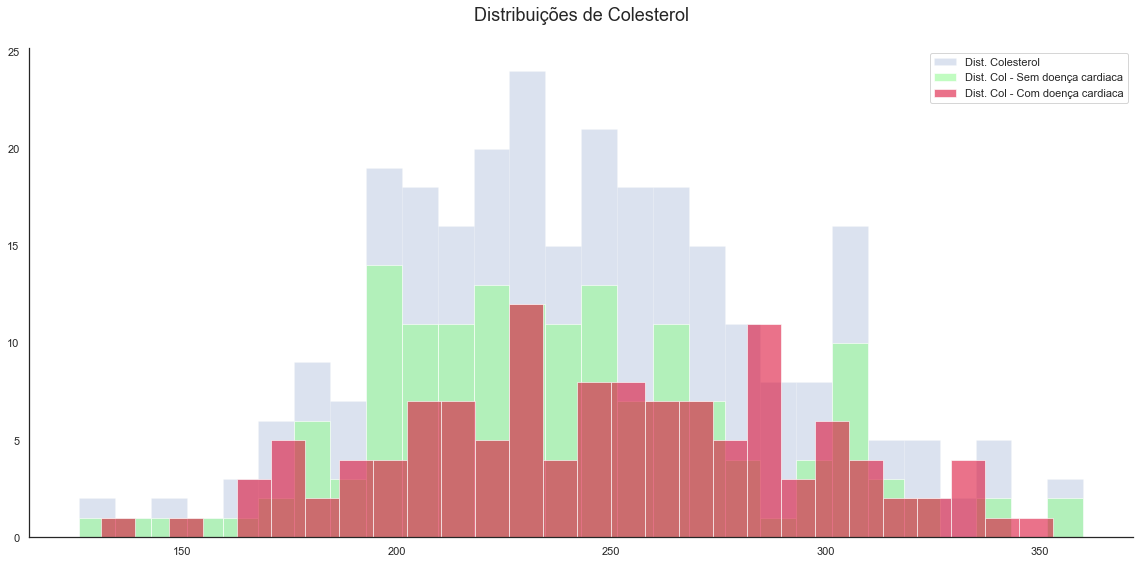

In [58]:
sns.set_style('white')

plt.figure(figsize=(16,8))
sns.distplot(df['colesterol'],  kde=False, bins=28, color='b',
             hist_kws=dict(alpha=.2), label="Dist. Colesterol")

sns.distplot(df[df['condicao']==0]['colesterol'], kde=False, bins=28, color='palegreen',
             hist_kws=dict(alpha=.6),label="Dist. Col - Sem doença cardiaca")

sns.distplot(df[df['condicao']==1]['colesterol'], kde=False, bins=28, color='crimson',
             hist_kws=dict(alpha=.6),label="Dist. Col - Com doença cardiaca")


plt.title('Distribuições de Colesterol\n',  fontdict={'size':18})
plt.xlabel('')
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

A distribuição de níveis de colesterol parece ser parecida entre ambos grupos, com o grupo positivo para doenças cardíacas apresentando valores mais altos.


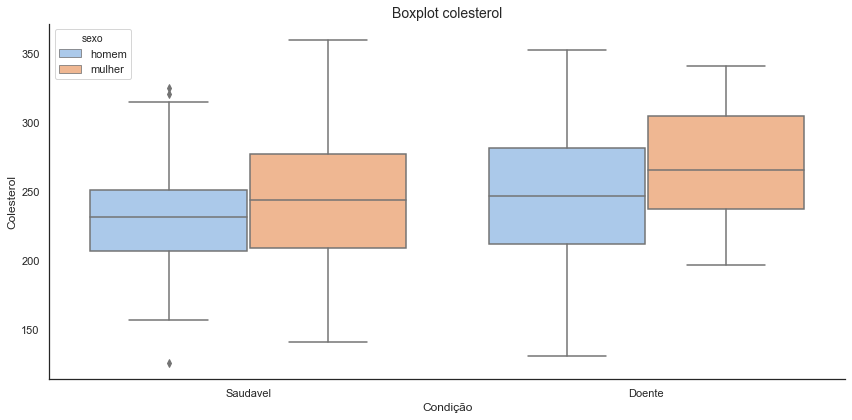

In [59]:
sns.set_style('white')
plt.figure(figsize=(12,6))

sns.boxplot(x='condicao',y='colesterol', hue='sexo', data=df, palette='pastel')

plt.title('Boxplot colesterol', fontdict={'size':14})
plt.ylabel('Colesterol')
plt.xlabel('Condição')

plt.xticks(ticks=[0,1], labels=['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

Como esperado depois do histograma, podemos ver que existe de fato uma diferença (apesar de pequena) entre os níveis de colesterol de pacientes 0 e 1. Também existe uma diferença entre sexos, com mulheres apresentando colesterol mais altos em ambos os grupos. 

Abaixo, podemos analisar as medianas de cada grupo:




In [60]:
print(
 "Mediana da coluna COLESTEROL: {}\n\n"
 "Mediana de COLESTEROL para pacientes saudaveis: {}\n"
 "Mediana de COLESTEROL para pacientes doentes: {}\n\n"
 "Mediana de COLESTEROL para homens: {}\n"
 "Mediana de COLESTEROL para homens doentes {}\n"
 "Mediana de COLESTEROL para homens saudaveis {}\n\n"
 "Mediana de COLESTEROL para mulheres: {}\n"
 "Mediana de COLESTEROL para mulheres doentes {}\n"
 "Mediana de COLESTEROL para mulheres saudaveis {}\n".format(
     df['colesterol'].median(),
     df[df['condicao'] == 0]['colesterol'].median(),
     df[df['condicao'] == 1]['colesterol'].median(),
     df[df['sexo'] == 'homem']['colesterol'].median(),
     df[(df['sexo'] == 'homem') & (df['condicao'] == 1)]['colesterol'].median(),
     df[(df['sexo'] == 'homem') & (df['condicao'] == 0)]['colesterol'].median(),
     df[df['sexo'] == 'mulher']['colesterol'].median(),
     df[(df['sexo'] == 'mulher') & (df['condicao'] == 1)]['colesterol'].median(),
     df[(df['sexo'] == 'mulher') & (df['condicao'] == 0)]['colesterol'].median()))

Mediana da coluna COLESTEROL: 240.0

Mediana de COLESTEROL para pacientes saudaveis: 234.5
Mediana de COLESTEROL para pacientes doentes: 249.0

Mediana de COLESTEROL para homens: 235.0
Mediana de COLESTEROL para homens doentes 247.0
Mediana de COLESTEROL para homens saudaveis 232.0

Mediana de COLESTEROL para mulheres: 250.0
Mediana de COLESTEROL para mulheres doentes 265.5
Mediana de COLESTEROL para mulheres saudaveis 244.0



Mulheres, tanto docentes quanto saudáveis, tendem a apresentar colesterol mais alto que homens.

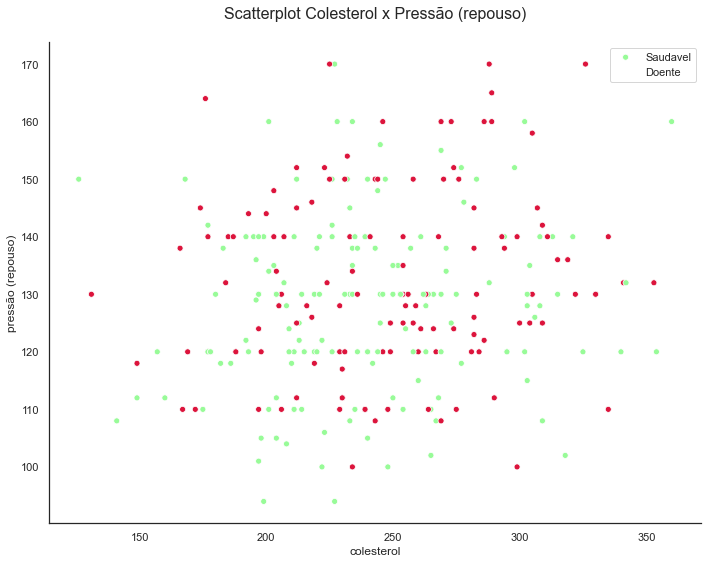

In [61]:
sns.set_style('white')
plt.figure(figsize=(10,8))

sns.scatterplot(x='colesterol',y='pressão (repouso)', data=df, hue='condicao', palette=colors)

plt.title('Scatterplot Colesterol x Pressão (repouso)\n',fontdict={'size':16})
sns.despine()
plt.legend(['Saudavel','Doente'])
plt.tight_layout()
plt.show()

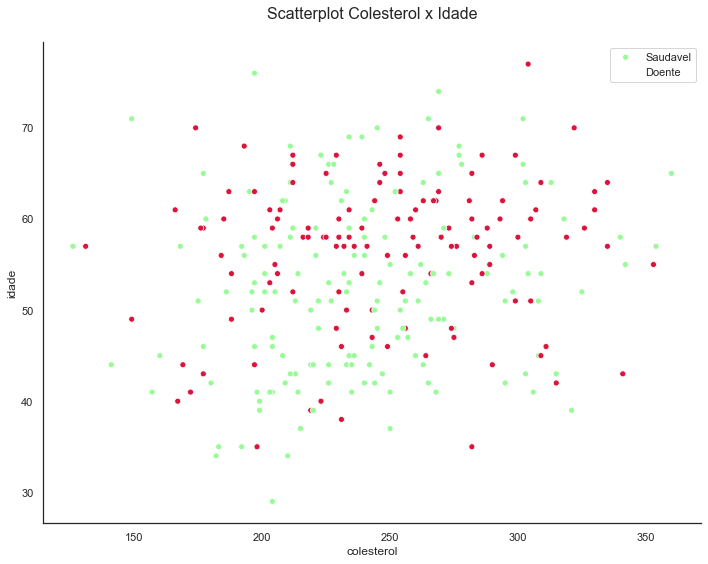

In [62]:
sns.set_style('white')
plt.figure(figsize=(10,8))

sns.scatterplot(x='colesterol',y='idade',data=df, hue='condicao', palette=colors)

plt.title('Scatterplot Colesterol x Idade\n',fontdict={'size':16})
sns.despine()
plt.legend(['Saudavel','Doente'])
plt.tight_layout()
plt.show()

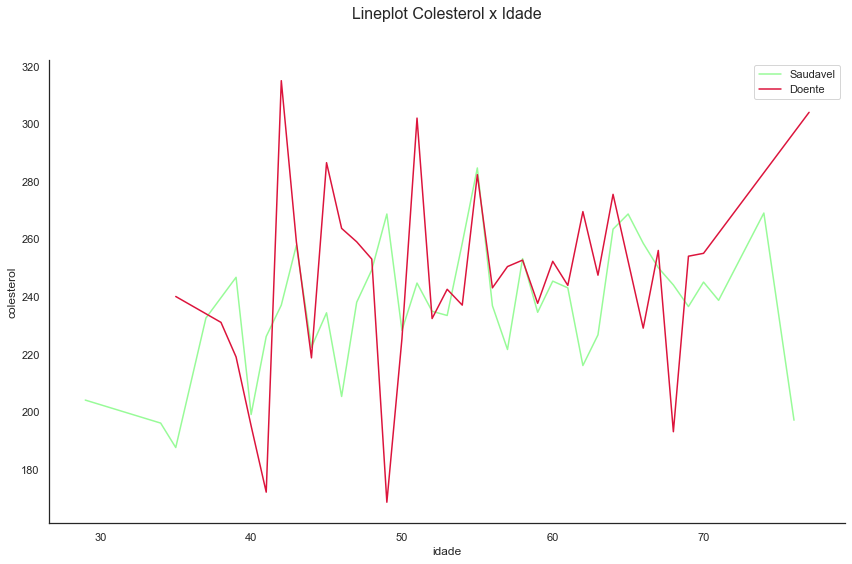

In [63]:
sns.set_style('white')
plt.figure(figsize=(12,8))
sns.lineplot(x='idade',y='colesterol', data=df, hue='condicao', palette=colors, ci=None)
plt.title('Lineplot Colesterol x Idade\n\n', fontdict={'size':16})

plt.legend(['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

Estranhamente, os gráficos entre colesterol e pressão (repouso) e colesterol e idade não apresentam tendências claras. 

Considerando que o valor considerado saudável é igual ou menor que 190mg/dL, é importante notar que a mediana de colesterol de TODOS os grupos analisados até aqui (com ou sem doença e por sexos) é consideravelmente maior que este valor. Essa alta generalizada de colesterol dos pacientes de nosso dataset pode (e provavelmente vai) acabar diminuindo a importância bibliograficamente comprovada da influencia dos níveis de colesterol em doenças cardíacas.

Aqui cabe uma discussão mais extensa sobre os estilos de vida da população onde o estudo foi realizado (Cleveland - EUA). 


**Glicose em jejum (fbs - fasting blood sugar)**

0 = valor menor que 120mg/dl

1 = valor maior que 120mg/dl  

Níveis de glicose em jejum. Valores altos podem indicar diabetes, condição altamente correlacionada com doenças cardíacas.
Valores considerados normais são:

Abaixo de 100mg/dl: Normal
Até 125mg/dl: Pré-diabetes
Acima de 126mg/dl: Diabetes

Neste dataframe, a única informação que temos é se o paciente possui um valor acima ou abaixo de 120mg/dl. Com esse dado, não podemos afirmar que o paciente é ou não é diabetico, somente considerar que o mesmo possui ou não possui altos níveis de glicose em jejum.

Alterarei os valores para "menor que 120mg" e "maior que 120mg" para tornar a fase de EDA mais descritiva. 

Fonte:

https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html




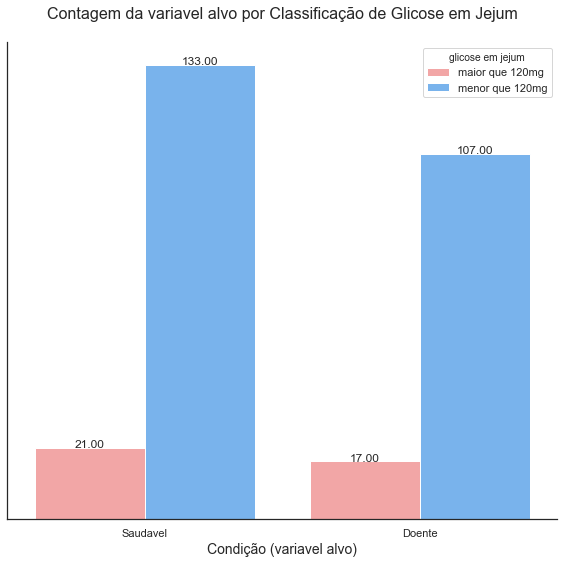

In [64]:
sns.set_style('white')
plt.figure(figsize=(8,8))
colors = ['#ff9999','#66b3ff']
ax = sns.countplot('condicao',hue='glicose em jejum',data=df, palette=colors)
show_values_on_bars(ax)

plt.ylabel('')
plt.xlabel('Condição (variavel alvo)', fontdict={'size':14})
plt.title('Contagem da variavel alvo por Classificação de Glicose em Jejum\n', fontdict={'size':16})
plt.yticks(ticks=[])
plt.xticks(ticks=[0,1], labels=['Saudavel','Doente'])

sns.despine()
plt.tight_layout()
plt.show()

Novamente, temos uma distribuição muito parecida entre ambos os grupos. A variável Glicose em Jejum é bem balanceada entre doentes e não-doentes. Parece que não será um bom indicador de doenças cardíacas por si só.

**ECG em repouso (restecg: resting electrocardiographic results)**

Resultados do exame de eletrocardiograma realizado em repouso.

0 = Normal

1 = Anormalidade no segmento ST ou onda T do eletrocardiograma

2 = Hipertrofia ventricular segundo criterio de Estes (https://en.ecgpedia.org/wiki/Romhilt-Estes_Score)

Pacientes com quadros menos graves tendem a apresentar anormalidades somente durante atividades de estresse. Resultados de ECG anormais em situação de repouso podem ser indicativos de um possível quadro mais grave de doença cardíaca. O segmento ST representa o período de inatividade elétrica depois do miocárdio estar despolarizado enquanto a onda T representa a repolarização dos ventrículos.

As alterações do segmento ST/onda T são de grande importância no diagnóstico das síndromes coronarianas agudas. A imagem abaixo compara um ECG normal com exemplos de variação ST-T:

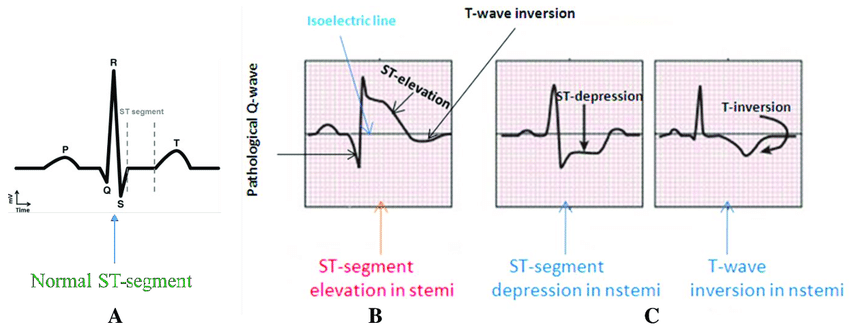

Pacientes que apresentarem valor "2" nesta coluna foram diagnosticados com hipertrofia ventricular. Pressão alta e doenças cardíacas aumentam o esforço cardíaco necessário para manter o funcionamento do corpo. Sendo um músculo, esse aumento de esforço causa uma hipertrofia (geralmente presente no ventrículo esquerdo). Apesar de ser uma condição altamente correlacionada com quadros de patologia cardiaca, hipertrofias ventriculares também podem ser encontradas em atletas de alto nível. 

Nesta variável, manterei os valores como 0, 1 e 2, pois é importante que haja a intuição que um quadro de hipertrofia ventricular é "mais grave" que somente presença de anormalidade de ST.

Fontes:

https://www.mayoclinic.org/diseases-conditions/left-ventricular-hypertrophy/symptoms-causes/syc-20374314

https://pebmed.com.br/sindrome-coronariana-com-supra-st-como-avaliar-o-eletrocardiograma/

https://www.researchgate.net/figure/Comparison-of-the-ST-segment-variations-in-a-normal-subject-A-and-in-MI-patients-with_fig1_333912486





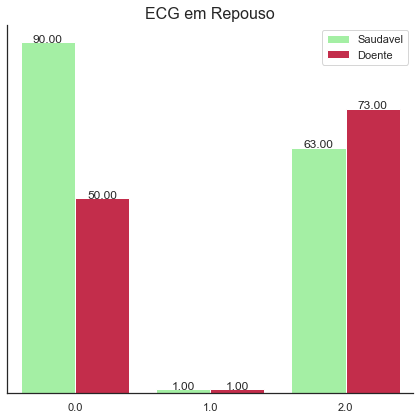

In [65]:
sns.set_style('white')
plt.figure(figsize=(6,6))

colors = ['palegreen','crimson']
ax = sns.countplot('ECG em repouso', hue='condicao', data=df, palette=colors)
show_values_on_bars(ax)

plt.title('ECG em Repouso', fontdict={'size':16})
plt.ylabel('')
plt.xlabel('')
plt.yticks(ticks=[])

plt.legend(['Saudavel','Doente'])
plt.tight_layout()
sns.despine()
plt.show()


Parece que temos pouquíssimos pacientes na categoria 1 (Anormalidade no segmento ST ou onda T do eletrocardiograma). A existência de uma categoria com tão poucos pacientes pode acabar atrapalhando nosso modelo. Vamos remover estes pacientes do dataframe.


In [66]:
drop_ecg = df[df['ECG em repouso'] == 1].index

In [67]:
df = df.drop(drop_ecg, axis=0)

In [68]:
df['ECG em repouso'] = df['ECG em repouso'].cat.remove_unused_categories()

In [69]:
df['ECG em repouso'] = df['ECG em repouso'].replace({0:'normal',2:'hipertrofia ventricular'})

In [70]:
df['ECG em repouso'] = pd.Categorical(df['ECG em repouso'])

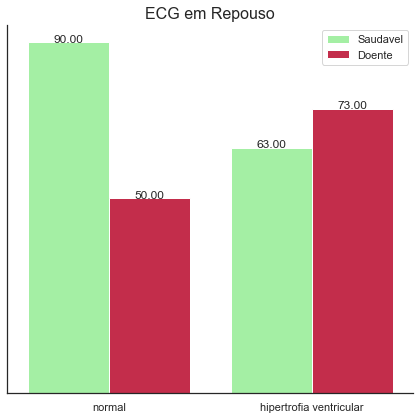

In [71]:
sns.set_style('white')
plt.figure(figsize=(6,6))

ax = sns.countplot('ECG em repouso', hue='condicao', data=df, palette=colors, order=['normal','hipertrofia ventricular'])
show_values_on_bars(ax)

plt.title('ECG em Repouso', fontdict={'size':16})
plt.ylabel('')
plt.xlabel('')
plt.yticks(ticks=[])

plt.legend(['Saudavel','Doente'])
plt.tight_layout()
sns.despine()
plt.show()


Como explicado no início do notebook os valores da variável ECG em repouso (0, 1 e 2) representam respectivamente:

0 = Normal

1 = Anormalidade no segmento ST ou onda T do eletrocardiograma (agora removidos)

2 = Hipertrofia ventricular

Apesar de os valores entre pacientes doentes e saudáveis na categoria de hipertrofia ventricular serem relativamente parecidos (havendo mais pacientes doentes que saudáveis, como esperado), o que mais chama atenção neste gráfico é a suposta "proteção" que possuir um ECG em repouso normal pode conceder a um paciente. Em pacientes com ECG normal, temos quase o dobro de saudáveis do que doentes.


**Frequência cardíaca máxima em stress (thalach: maximum heart rate achieved)**

Valor da frequência cardíaca máxima durante estresse em bpm. O cálculo feito para encontrar o valor máximo é 220 - Idade. Isso significa é que é comum para pacientes mais jovens terem a frequência máxima mais alta. 

Contudo, o valor de um paciente ser mais baixo que o 220 - Idade não significa necessariamente patologia. A taxa ideal para um exercício moderado é de 50% até 70% de sua frequência cardíaca máxima, enquanto para exercícios intensos, a taxa ideal é até 85%.  Esta é uma variável complicada de interpretar, pois não temos informações sobre o nível (e duração) do exercício (estresse) ao qual o paciente foi induzido. 

Descobriremos mais sobre essa variável durante a EDA.

Fontes:

https://www.healio.com/cardiology/learn-the-heart/cardiology-review/topic-reviews/stress-testing-review

https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you

https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates




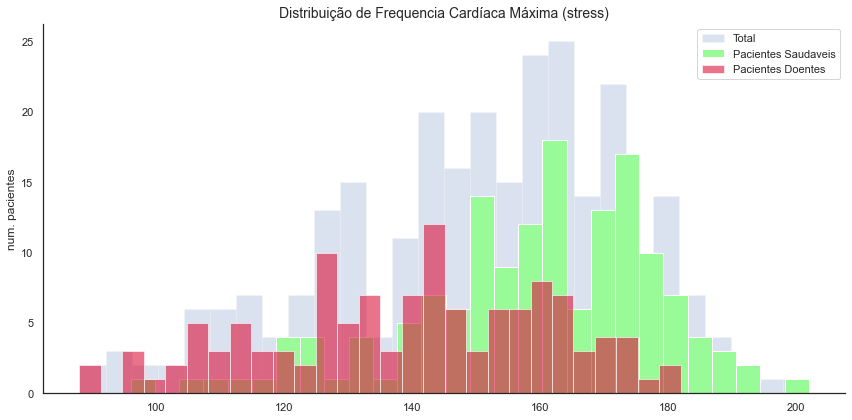

In [72]:
sns.set_style('white')
plt.figure(figsize=(12,6))


sns.distplot(df['frequência cardíaca máxima (stress)'], kde=False, bins=28, color='b',
             hist_kws=dict(alpha=.2), label="Total")

sns.distplot(df[df['condicao'] == 0]['frequência cardíaca máxima (stress)'], kde=False, bins=28, color='palegreen',
             hist_kws=dict(alpha=1), label="Pacientes Saudaveis")
sns.distplot(df[df['condicao'] == 1]['frequência cardíaca máxima (stress)'], kde=False, bins=28, color='crimson',
             hist_kws=dict(alpha=0.6), label="Pacientes Doentes")

plt.title('Distribuição de Frequencia Cardíaca Máxima (stress)', fontdict={'size':14})
plt.xlabel('')
plt.ylabel('num. pacientes')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

Aparentemente, a frequência cardíaca máxima dos pacientes saudáveis é maior do que a de pacientes acometidos por doenças cardíacas. Há várias maneiras de se olhar para esse resultado:

Por um lado, esperamos frequências cardíacas mais altas de pacientes com corações comprometidos, pois o coração teria que trabalhar mais duro para bombear a quantidade necessária de sangue durante exercício físico como forma de compensar seu mal funcionamento.

Por outro lado, vimos acima que na distribuição de idades que pacientes sem doenças cardíacas tendem a ser mais jovens, e sabendo que o cálculo de frequência cardíaca máxima ideal é 220 - Idade, faz sentido que a distribuição para pacientes sem doenças cardíacas (presumindo que estes pacientes "saudáveis" possuem  valor de frequencia máxima próximo do ideal) possua valores maiores.


In [73]:
print(f"Mediana de Idade de pacientes saudaveis: {df[df['condicao'] == 0]['idade'].median()}")
print(f"Mediana de Idade de pacientes doentes: {df[df['condicao'] == 1]['idade'].median()}")

Mediana de Idade de pacientes saudaveis: 52.0
Mediana de Idade de pacientes doentes: 58.0


De fato, a mediana de idade dos pacientes doentes possui um valor maior do que a dos saudáveis, mas a diferença não é grande o suficiente para sozinha explicar a distribuição mais elevada de Frequencia Cardiaca Maxima.

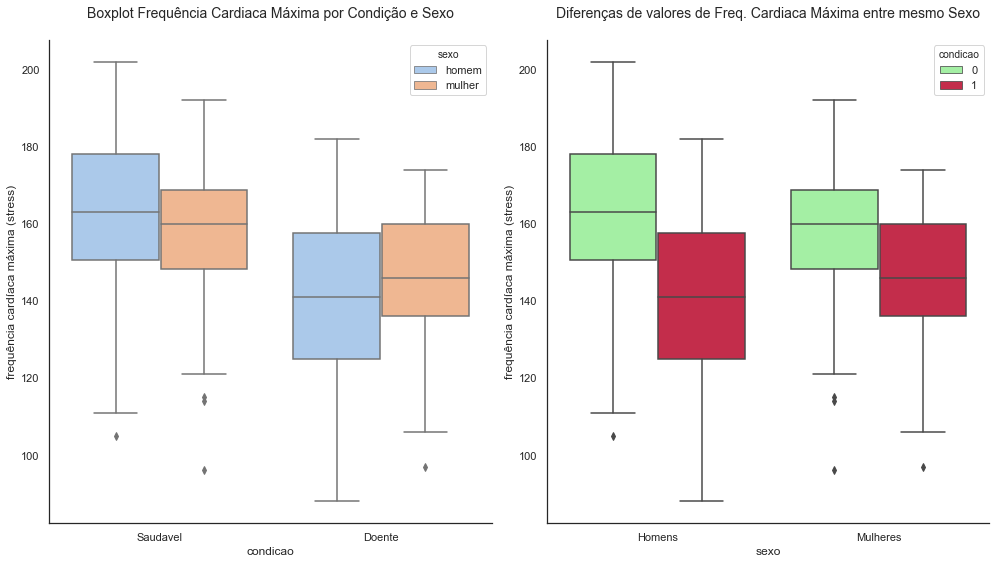

In [74]:
sns.set_style('white')
fig, ax = plt.subplots(1,2,figsize=(14,8))

sns.boxplot(y='frequência cardíaca máxima (stress)',x='condicao', hue='sexo', data=df, orient='v', palette='pastel', ax=ax[0])
sns.boxplot(y='frequência cardíaca máxima (stress)',x='sexo', hue='condicao', data=df, orient='v', palette=colors, ax=ax[1])

ax[0].set_title('Boxplot Frequência Cardiaca Máxima por Condição e Sexo\n', fontdict={'size':14})
ax[1].set_title('Diferenças de valores de Freq. Cardiaca Máxima entre mesmo Sexo\n', fontdict={'size':14})

plt.sca(ax[0])
plt.xticks(range(2), ['Saudavel','Doente'])

plt.sca(ax[1])
plt.xticks(range(2), ['Homens','Mulheres'])


plt.tight_layout()
sns.despine()
plt.show()

O primeiro boxplot corrobora com o histograma, afirmando que pacientes saudáveis costumam possuir valores mais altos da variável Frequência Cardíaca Máxima (stress) que pacientes doentes. Parece que os valores se comportam de maneiras semelhantes entre sexos, com tanto homens e mulheres saudáveis possuindo valores consideravelmente mais baixos de Frequência Cardíaca Máxima (stress) que homens e mulheres doentes.

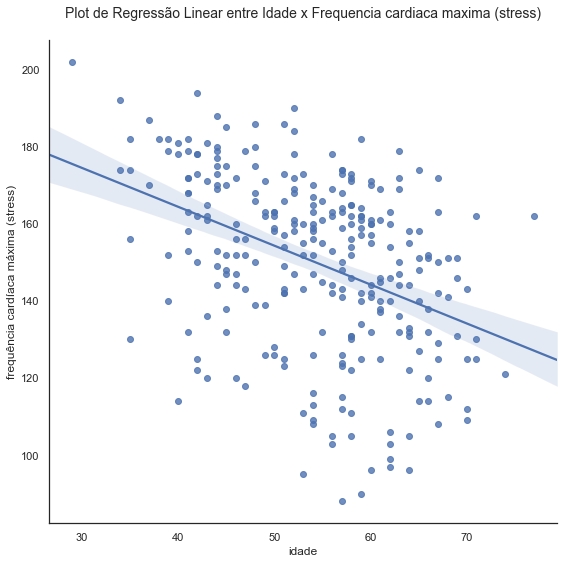

In [75]:
sns.set_style('white')

sns.lmplot(x='idade', y='frequência cardíaca máxima (stress)', data=df, height=8)
ax = plt.gca()
ax.set_title("Plot de Regressão Linear entre Idade x Frequencia cardiaca maxima (stress)\n", fontdict={'size':14})

plt.tight_layout()
plt.show()

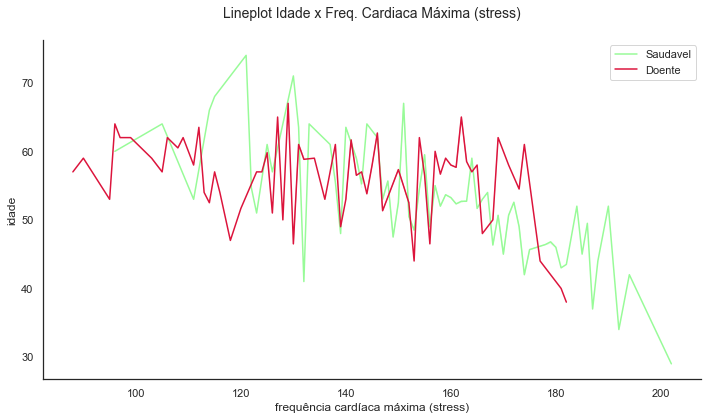

In [76]:
plt.figure(figsize=(10,6))
sns.lineplot(x='frequência cardíaca máxima (stress)', y='idade',hue='condicao', data=df, ci=False, palette=colors)


plt.title('Lineplot Idade x Freq. Cardiaca Máxima (stress)\n', fontdict={'size':14})
plt.legend(['Saudavel','Doente'])
plt.tight_layout()
sns.despine()
plt.show()

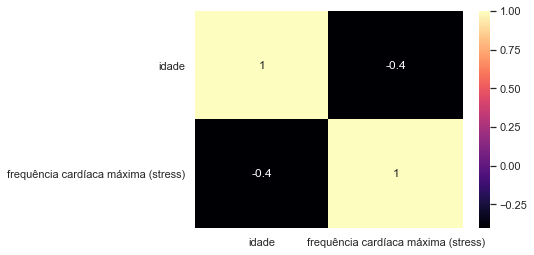

In [77]:
sns.heatmap(df[['idade','frequência cardíaca máxima (stress)']].corr(), annot=True, cmap='magma')
plt.yticks(rotation=0)

plt.show()

A regressão linear e o mapa de calor nos mostra que de fato, existe uma correlação negativa, mesmo que relativamente baixa (-0.41) entre frequencia cardiaca maxima (stress) e idade.

**Angina stress (exang)**

Presença de Angina durante exercício (estresse).

0 = Sem angina durante estresse

1 = Com angina durante estresse

Essa variável possivelmente possui alta correlação a doenças cardíacas, principalmente se cruzarmos com a variável Dor Torácica para confirmar que trata-se de angina típica ou atípica e não dores não-anginais, ou cruzarmos pacientes que não apresentaram angina durante estresse com assintomáticos para Dor Toracica.

Novamente, alterarei os valores para "com angina" e "sem angina" para tornarmos o dataset mais descritivo. 




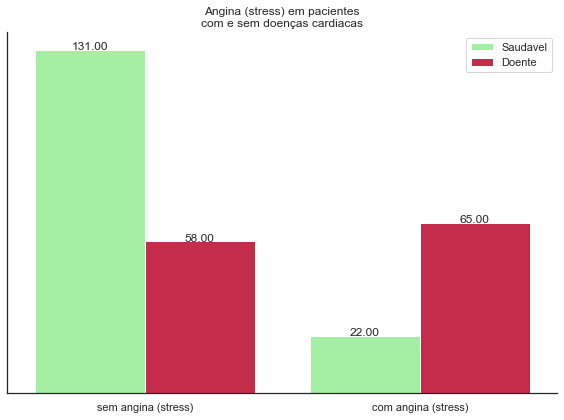

In [78]:
sns.set_style('white')
plt.figure(figsize=(8,6))

ax = sns.countplot('angina (stress)', hue='condicao', data=df, palette=colors, order=['sem angina (stress)','com angina (stress)'])
show_values_on_bars(ax)

plt.title('Angina (stress) em pacientes\ncom e sem doenças cardiacas', fontdict={'size':12})
plt.ylabel('')
plt.xlabel('')
plt.yticks(ticks=[])

plt.legend(['Saudavel','Doente'])
plt.tight_layout()
sns.despine()
plt.show()

O gráfico está bem de acordo com o que esperávamos da variável: no grupo COM ANGINA possuímos mais pacientes com doenças cardíacas, enquanto no grupo SEM ANGINA, mais pacientes sem doenças cardíacas. 

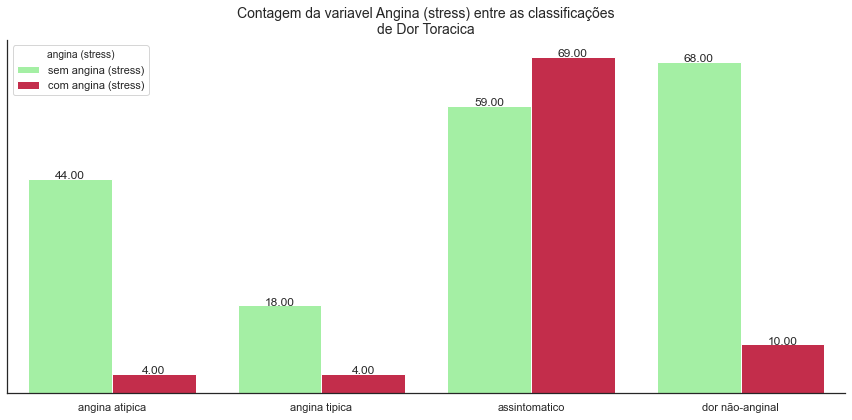

In [79]:
sns.set_style('white')
plt.figure(figsize=(12,6))

ax = sns.countplot('dor toracica', hue='angina (stress)', data=df, palette=colors, hue_order=['sem angina (stress)','com angina (stress)'])

show_values_on_bars(ax)

plt.title('Contagem da variavel Angina (stress) entre as classificações\nde Dor Toracica', fontdict={'size':14})
plt.ylabel('')
plt.xlabel('')
plt.yticks(ticks=[])

plt.tight_layout()
sns.despine()
plt.show()

No gráfico acima, contamos a variável angina (stress) em cada tipo de dor torácica presente no dataset. O grupo de assintomáticos (em repouso) foi o que mais apresentou angina durante o estresse.

É importante notar que apesar de ambas variáveis (angina (stress) e dor torácica) serem relativas a dores no peito, uma delas representa o tipo de dor enquanto em repouso e outra enquanto em atividade física. Esse gráfico nos dá uma ideia do quão complicado pode ser diagnosticar um paciente com suspeita de doença cardíaca, visto que o mesmo pode só apresentar sintomas em situações específicas (ou não apresentar sintomas e mesmo assim estar doente, como é o caso dos assintomáticos sem angina durante estresse).

Para ilustrar esse insight, vamos plotar os pacientes cuja variável dor torácica é assintomática e não apresentaram angina em estresse:




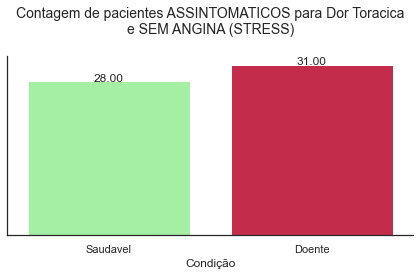

In [80]:
plt.figure(figsize=(6,4))
ax = sns.countplot(df[(df['angina (stress)'] == 'sem angina (stress)') & (df['dor toracica'] == 'assintomatico')]['condicao'],
                  palette=colors)
show_values_on_bars(ax)

plt.title('Contagem de pacientes ASSINTOMATICOS para Dor Toracica\ne SEM ANGINA (STRESS)\n', fontdict={'size':14})
plt.yticks(ticks=[])
plt.ylabel('')
plt.xlabel('Condição')
plt.xticks(ticks=[0,1], labels=['Saudavel','Doente'])
plt.tight_layout()
sns.despine()
plt.show()

Curiosamente, temos mais doentes que saudáveis nesta análise. Estes são pacientes que teoricamente não sentiam (ou relataram aos médicos) nenhum desconforto, e mesmo assim sofriam de doenças cardíacas.


**Valor ST (oldpeak)**

Valor de variação do segmento ST do eletrocardiograma. O segmento ST costuma ser isoelétrico em pacientes saudáveis (representado como uma linha reta no ECG). A variação deste segmento é obtida calculando a distância vertical entre a linha ST do paciente e a linha isoelétrica. Esta distância é causada por uma elevação ou depressão do segmento ST. Quanto maior o valor, maior a anormalidade do segmento.

Fontes:

https://www.ncbi.nlm.nih.gov/books/NBK459364/



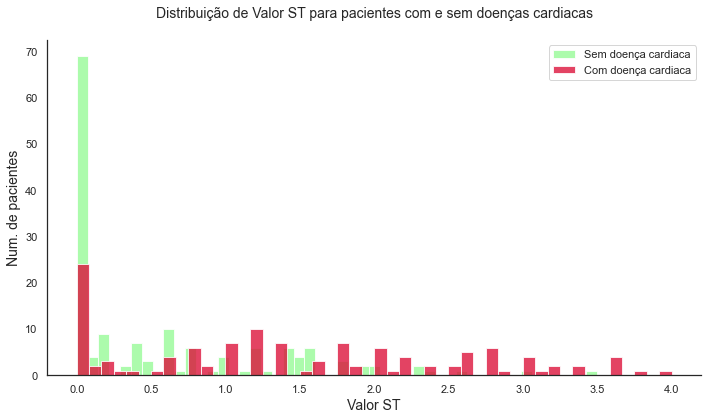

In [81]:
sns.set_style('white')
plt.figure(figsize=(10,6))
sns.distplot(df[df['condicao'] == 0]['valor ST'], kde=False, bins=48, color='palegreen', hist_kws=dict(alpha=.8),label="Sem doença cardiaca")
sns.distplot(df[df['condicao'] == 1]['valor ST'], kde=False, bins=48, color='crimson', hist_kws=dict(alpha=.8),label="Com doença cardiaca")


plt.xlabel('Valor ST', fontdict={'size':14})
plt.ylabel('Num. de pacientes', fontdict={'size':14})

plt.title('Distribuição de Valor ST para pacientes com e sem doenças cardiacas\n', fontdict={'size':14})
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

Valores ST indicam o quão distante a curva ST do eletrocardiograma está distante de seu ponto isoelétrico. Estar distante de seu ponto isoelétrico geralmente indica anomalia (linha não-reta). Neste histograma, conseguimos ver que a distribuição de pacientes saudáveis tente a ser mais próxima de 0, enquanto em pacientes doentes a distribuição é mais espalhada, incluindo valores mais altos. 

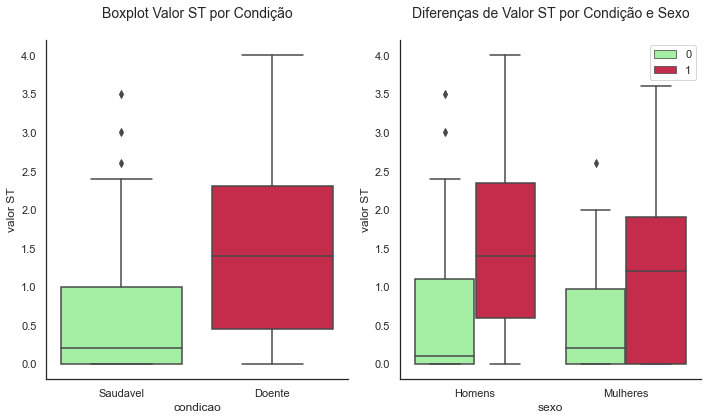

In [82]:
sns.set_style('white')
fig, ax = plt.subplots(1,2,figsize=(10,6))

sns.boxplot(y='valor ST', x='condicao', data=df, ax=ax[0], palette=colors)
sns.boxplot(y='valor ST', x='sexo', hue='condicao', data=df, ax=ax[1], palette=colors)

ax[0].set_title('Boxplot Valor ST por Condição\n', fontdict={'size':14})
ax[1].set_title('Diferenças de Valor ST por Condição e Sexo\n', fontdict={'size':14})

plt.sca(ax[0])
plt.xticks(range(2), ['Saudavel','Doente'])

plt.sca(ax[1])
plt.xticks(range(2), ['Homens','Mulheres'])

plt.legend()
plt.tight_layout()
sns.despine()
plt.show()


No boxplot, confirmamos que pacientes doentes tendem a apresentar valores ST maiores que pacientes saudáveis. Essa tendência se mantém em ambos sexos.


**Curva ST (slope)**

Este valor representa a curvatura do segmento ST (se presente) durante exercício. Como explicado acima, o segmento ST pode apresentar elevação, depressão ou estar reto.

1 = curva crescente

2 = segmento reto

3 = curva decrescente

Segundo a literatura, tanto elevações (1) quanto depressões (3) podem estar relacionadas a doenças como infarto do miocárdio, porém, existe uma grande discussão sobre a presença de falso positivos (15-20%) e falso negativos (20-30%) quando tratamos de elevações (curvas crescentes). 

Fontes:

https://www.dicardiology.com/article/technical-factors-involved-false-positive-ecg-stemi-diagnoses

https://en.wikipedia.org/wiki/ST_segment#cite_note-1

https://www.sciencedirect.com/science/article/pii/S073646791101136X

https://www.ncbi.nlm.nih.gov/books/NBK459364/





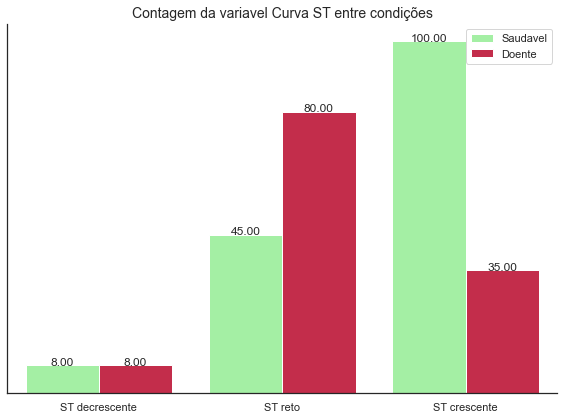

In [83]:
plt.figure(figsize=(8,6))

ax = sns.countplot('curva ST', hue='condicao', data=df, palette=colors,
                   order=['ST decrescente', 'ST reto', 'ST crescente'])

show_values_on_bars(ax)

plt.title('Contagem da variavel Curva ST entre condições', fontdict={'size':14})
plt.ylabel('')
plt.xlabel('')
plt.yticks(ticks=[])

plt.legend(['Saudavel','Doente'])
plt.tight_layout()
sns.despine()
plt.show()

Normalmente, um paciente saudável possui um ST reto em seu eletrocardiograma. Neste dataset, encontramos mais pacientes doentes do que saudáveis na categoria ST reto. Apesar da literatura citar a falta de confiabilidade (devido a alta taxa de falsos positivos e falsos negativos) da categoria ST crescente, ainda trata-se de uma anormalidade. É surpreendente que tenhamos mais pacientes saudáveis nessa categoria, assim como é surpreendente que a categoria ST decrescente seja balanceada (esperava-se que houvessem mais doentes que saudáveis).

A análise desta variável mostrou resultados contra-intuitivos. Devemos lembrar que nosso dataset possui um número relativamente pequeno de pacientes, limitados a um único hospital. Mesmo indo contra ao que esperávamos (com base na literatura médica), é possível que esta seja uma simples particularidade do recorte de pacientes.

Devemos analisar esta variável juntamente de "valor ST", visto que são "dois lados da mesma moeda", sendo uma o tipo de anormalidade presente e outra sua respectiva grandeza numérica.


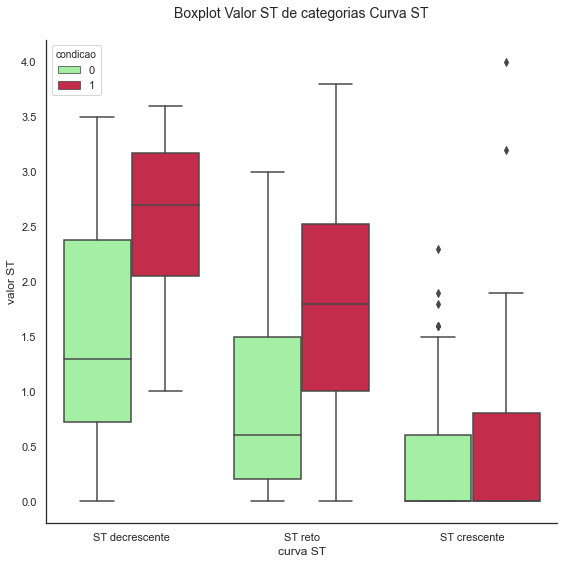

In [84]:
sns.set_style('white')
plt.figure(figsize=(8,8))

sns.boxplot(y='valor ST', x='curva ST', hue='condicao' , data=df,  palette=colors,
           order=['ST decrescente', 'ST reto', 'ST crescente'])

plt.title('Boxplot Valor ST de categorias Curva ST\n',fontdict={'size':14})


plt.tight_layout()
sns.despine()
plt.show()


Com a adição da variável "valor ST", ganhamos alguns insights. O tipo de anormalidade não é suficiente para determinar presença de doença cardíaca (exemplo: apenas saber que paciente X possui curva ST decrescente). Com seu respectivo valor numérico, podemos ver que há grande diferença de valores entre pacientes doentes e saudáveis para cada tipo de anormalidade.

Pode ser estranho notar que há valores "altos" em pacientes da categoria ST reto, mas temos que lembrar que a existência de valores entre 1 a 1.5 mm podem ser frequentemente achados em pacientes saudáveis. O valor ST crescente não está muito claro. Mais para frente vamos analisar se devemos dropa-lo.



**Defeito de perfusão (thal)**

Sem defeito

Defeixo reversível

Defeito fixo

Perfusão cardíaca pode se referir a uma série de exames dinâmicos de imagem onde é injetado no paciente contraste ou material radioativo (dependendo do exame) para analisar o fluxo sanguíneo e a absorção deste material no miocárdio (músculo cardíaco) durante repouso e estresse. É possível diagnosticar estenoses (estreitamento de vasos sanguíneos) e isquemias (falta de fornecimento sanguíneo) ao analisar estas imagens.

Um defeito reversível é caracterizado parte do músculo cardíaco absorve o material radioativo pelo tecido durante a fase de repouso, mas não durante a fase de estresse. Um defeito fixo é quando parte do músculo cardíaco não absorve o material em nenhuma das fases (geralmente causado por necrose ou fibrose do tecido em questão, sugerindo quadro mais grave).

No dataset original, estes valores estão representados como 3, 6, 7 e ? (representando NaNs). Estes foram modificados aqui (no início do notebook) para suas representações.

Fontes:

https://www.healio.com/cardiology/learn-the-heart/cardiology-review/topic-reviews/stress-testing-review

https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0066-782X2002000900001&lng=pt&nrm=iso&tlng=pt

https://en.wikipedia.org/wiki/Cardiac_magnetic_resonance_imaging_perfusion




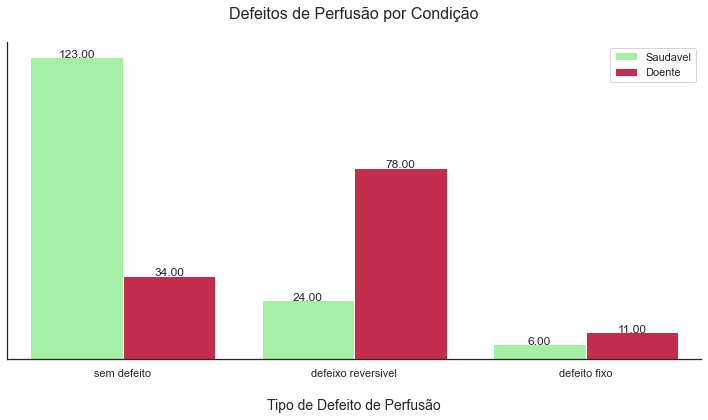

In [85]:
sns.set_style('white')
plt.figure(figsize=(10,6))

ax = sns.countplot('defeito de perfusão', hue='condicao', data=df, palette=colors,
                  order=['sem defeito','defeixo reversivel','defeito fixo'])
show_values_on_bars(ax)

plt.ylabel('')
plt.xlabel('\nTipo de Defeito de Perfusão', fontdict={'size':14})
plt.title('Defeitos de Perfusão por Condição\n', fontdict={'size':16})
plt.yticks(ticks=[])

plt.legend(['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

Outra variável cujo resultado é dentro do esperado. A categoria "sem defeito" parece conferir um fator protetivo alto para doenças cardíacas, com quase quatro vezes mais pacientes saudáveis do que doentes. Nos pacientes que apresentaram algum tipo de defeito por perfusão (reversível ou fixo), temos um número maior de doentes quando comparado ao numero de saudáveis, como esperado. 

**Num vasos (ca)**

Segundo a descrição do dataset, esta variável representa o número de grandes vasos cardíacos coloridos pelo contraste/material radioativo durante a fluoroscopia (outro exame de imagem dinâmico). Neste exame, o material é injetado no paciente via cateter e podemos analisar o fluxo sanguíneo do paciente via raio-X. 

Os valores variam entre inteiros de 0 a 3. Na prática, em um paciente saudável, seríamos capazes de observar o material radioativo em todos os principais vasos (ou seja, ausência de complicações cardíacas e circulação sanguínea normal). 

Infelizmente o formato desta variável não está claro: O coração possui mais de 3 grandes vasos (veia cava superior, veia cava inferior, tronco pulmonar, artéria pulmonar direita e esquerda, aorta, entre outros), logo, quais destes vasos os valores 0,1,2 e 3 representam? Se a variável representa a simples presença de contraste nestes vasos, não podemos considerar que este valor é uma simples contagem, pois muitos pacientes possuem o valor "0", o que não faria sentido em um exame de imagem que significaria a falta completa de função cardíaca. 

Pensando desta forma, faz mais sentido que este valor se refere a número de grandes vasos COM ANORMALIDADES encontrados via fluoroscopia (num. de grandes vasos com estenose, estreitamento, afins). Desta forma, damos sentido aos valores 0 e também entendemos que a variável pare em "3" (já que a existência de mais de 3 grandes vasos com anormalidades possivelmente teria levado o paciente a óbito antes do próprio exame).



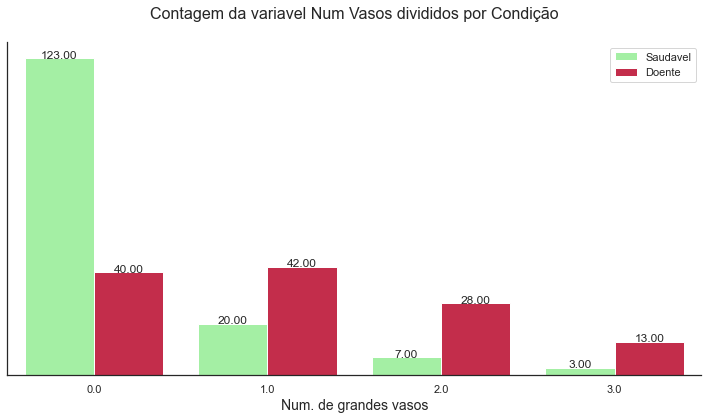

In [86]:
sns.set_style('white')
plt.figure(figsize=(10,6))

ax = sns.countplot('num vasos', hue='condicao', data=df, palette=colors)
show_values_on_bars(ax)

plt.ylabel('')
plt.xlabel('Num. de grandes vasos', fontdict={'size':14})
plt.title('Contagem da variavel Num Vasos divididos por Condição\n', fontdict={'size':16})
plt.yticks(ticks=[])

plt.legend(['Saudavel','Doente'])
sns.despine()
plt.tight_layout()
plt.show()

Analisando estes resultados, faz muito mais sentido pensar que o valor representa a quantidade de grandes vasos com anormalidades identificadas via fluoroscopia com contraste. Isto explicaria a presença de tantos pacientes saudáveis no valor "0", enquanto todos os outros valores (presença de 1, 2 ou 3 anormalidades em grandes vasos) apresentam mais pacientes doentes que saudáveis.


Pairplot:

In [87]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

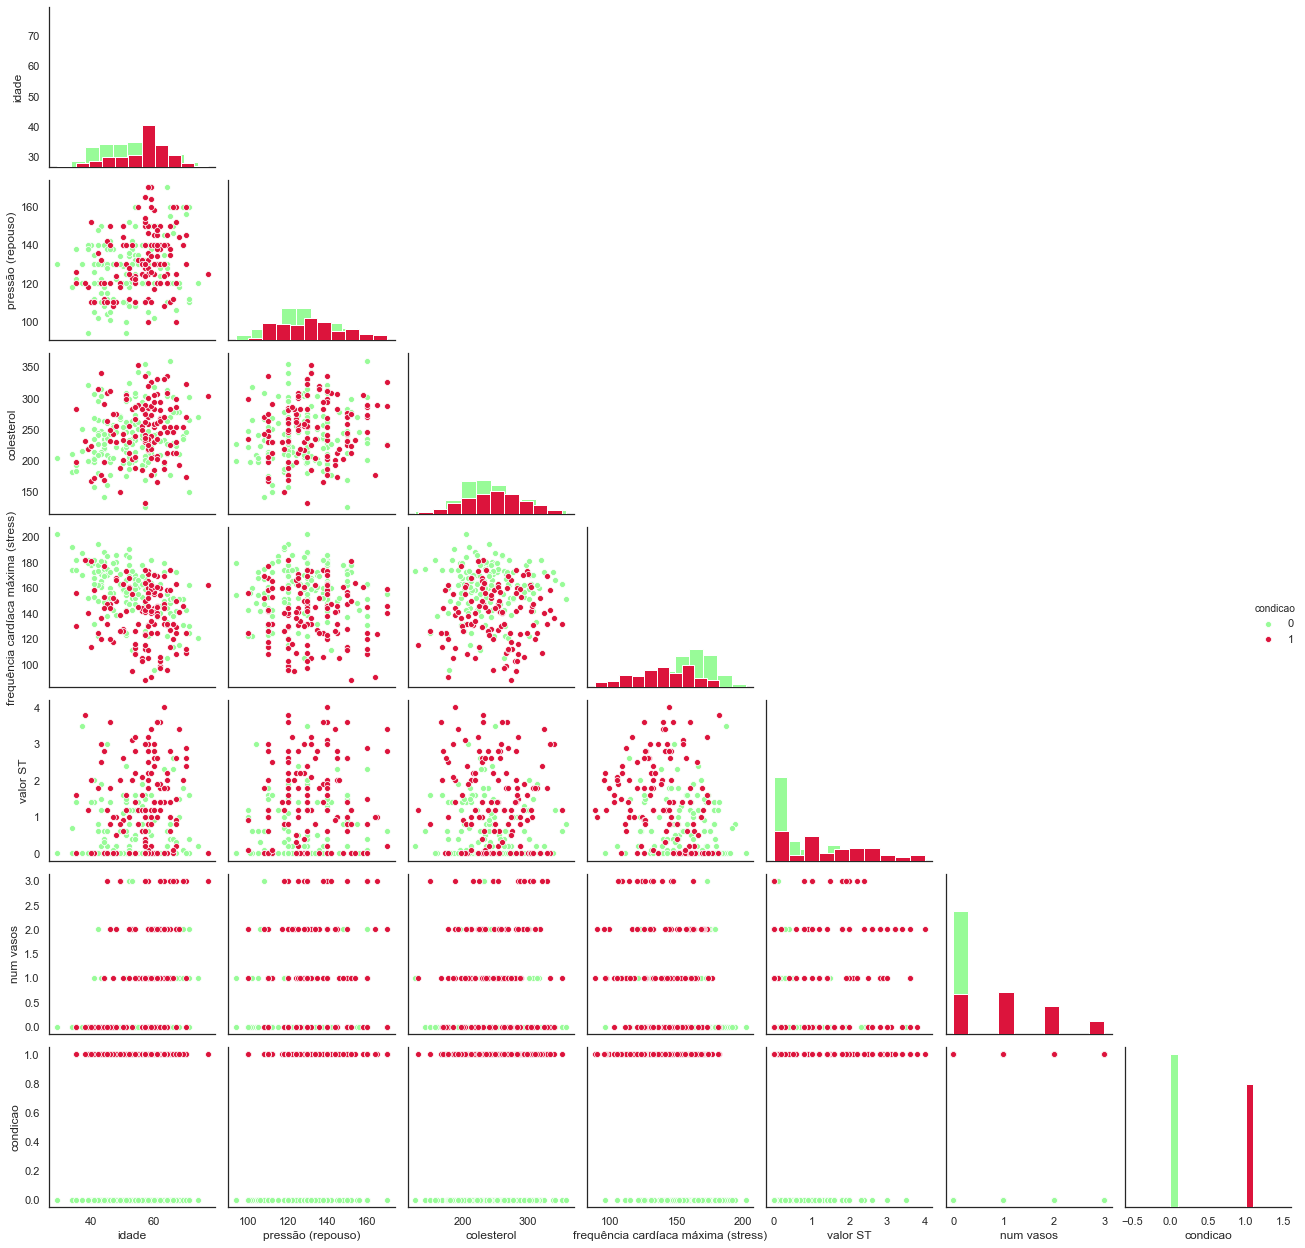

In [88]:
g = sns.pairplot(df, hue='condicao', plot_kws={'alpha':1}, diag_kind="hist", palette=colors)
g.map_upper(hide_current_axis)

plt.tight_layout()
plt.legend()
plt.show()


# Preparando para o modelo:

Temos que ajustar nossas variaveis para o modelo. Faremos alguns encoding e voltaremos algumas de nossas variaveis (como sexo) para binarias.

In [89]:
cols = ['idade',
 'sexo',
 'dor toracica',
 'pressão (repouso)',
 'colesterol',
 'glicose em jejum',
 'ECG em repouso',
 'frequência cardíaca máxima (stress)',
 'angina (stress)',
 'valor ST',
 'curva ST',
 'num vasos',
 'defeito de perfusão',
 'class pressão',
 'class colesterol',
 'condicao']

In [90]:
df = df[cols]

In [91]:
df.head()

,idade,sexo,dor toracica,pressão (repouso),colesterol,glicose em jejum,ECG em repouso,frequência cardíaca máxima (stress),angina (stress),valor ST,curva ST,num vasos,defeito de perfusão,class pressão,class colesterol,condicao
0,63,homem,angina tipica,145.0,233.0,maior que 120mg,hipertrofia ventricular,150.0,sem angina (stress),2.3,ST decrescente,0.0,defeito fixo,hipertensao 1,alto,0
1,67,homem,assintomatico,160.0,286.0,menor que 120mg,hipertrofia ventricular,108.0,com angina (stress),1.5,ST reto,3.0,sem defeito,hipertensao 2,alto,1
2,67,homem,assintomatico,120.0,229.0,menor que 120mg,hipertrofia ventricular,129.0,com angina (stress),2.6,ST reto,2.0,defeixo reversivel,normal,alto,1
3,37,homem,dor não-anginal,130.0,250.0,menor que 120mg,normal,187.0,sem angina (stress),3.5,ST decrescente,0.0,sem defeito,limitrofe,alto,0
4,41,mulher,angina atipica,130.0,204.0,menor que 120mg,hipertrofia ventricular,172.0,sem angina (stress),1.4,ST crescente,0.0,sem defeito,limitrofe,alto,0


In [92]:
features_para_encoding = ['sexo', 'dor toracica','glicose em jejum','ECG em repouso',
                          'angina (stress)','curva ST', 'defeito de perfusão','class pressão',
                          'class colesterol','condicao']

In [93]:
le = preprocessing.LabelEncoder()

In [94]:
for feature in features_para_encoding:
    df[feature] = le.fit_transform(df[feature])

<AxesSubplot:>

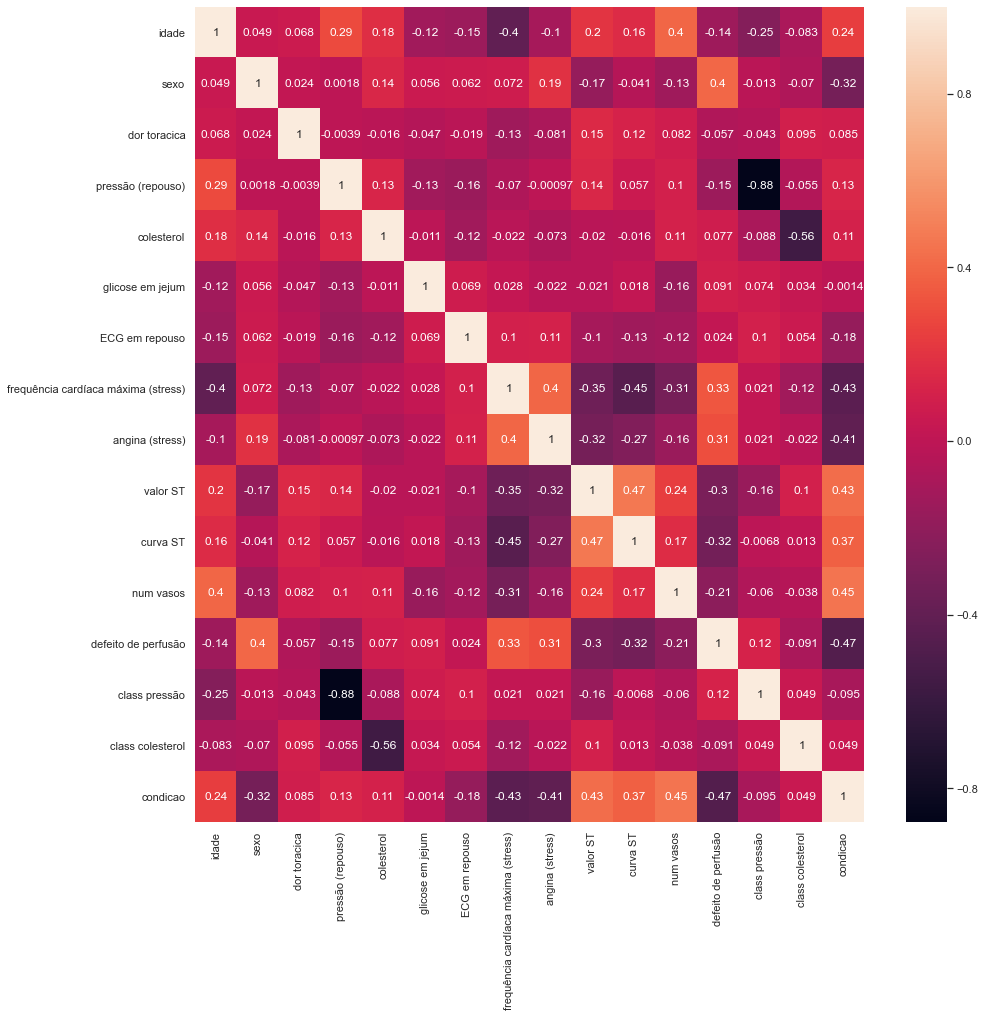

In [95]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

Parece que as variáveis "glicose em jejum, class colesterol, class pressão e dor toracica" possuem correlações muito baixas com nossa variável alvo. Vamos removê-las do dataframe caso contrário adicionarão ruído aos nossos dados.


In [96]:
print(f"Correlação entre glicose em jejum e variavel alvo: {df['glicose em jejum'].corr(df['condicao']):.4f}")
print(f"Correlação entre class colesterol e variavel alvo: {df['class colesterol'].corr(df['condicao']):.4f}")
print(f"Correlação entre class pressão e variavel alvo: {df['class pressão'].corr(df['condicao']):.4f}")
print(f"Correlação entre dor toracica_angina tipica e variavel alvo: {df['dor toracica'].corr(df['condicao']):.4f}")

Correlação entre glicose em jejum e variavel alvo: -0.0014
Correlação entre class colesterol e variavel alvo: 0.0494
Correlação entre class pressão e variavel alvo: -0.0955
Correlação entre dor toracica_angina tipica e variavel alvo: 0.0847


In [97]:
df = df.drop(columns=['glicose em jejum','class colesterol','class pressão','dor toracica'])

In [98]:
X = df.drop(columns='condicao')
Y = df['condicao']

Y:

In [99]:
Y.value_counts()

0    153
1    123
Name: condicao, dtype: int64

X:

In [100]:
X.head()

,idade,sexo,pressão (repouso),colesterol,ECG em repouso,frequência cardíaca máxima (stress),angina (stress),valor ST,curva ST,num vasos,defeito de perfusão
0,63,0,145.0,233.0,0,150.0,1,2.3,1,0.0,0
1,67,0,160.0,286.0,0,108.0,0,1.5,2,3.0,2
2,67,0,120.0,229.0,0,129.0,0,2.6,2,2.0,1
3,37,0,130.0,250.0,1,187.0,1,3.5,1,0.0,2
4,41,1,130.0,204.0,0,172.0,1,1.4,0,0.0,2


Olhando nosso dataframe X, percebemos que nossas variáveis possuem intervalos muito distintos. Compare por exemplo "num vasos", que vai de 1 até 4 com colesterol, que possui valores acima de 200. Este tipo de diferença entre valores pode atrapalhar o funcionamento de nosso modelo. Para isso, iremos normalizar os dados:

In [101]:
scaler = StandardScaler()
standard_X = scaler.fit_transform(X)

In [102]:
dados_para_modelo = pd.DataFrame(standard_X, columns = X.columns)

X Standarizado:

In [103]:
dados_para_modelo.head()

,idade,sexo,pressão (repouso),colesterol,ECG em repouso,frequência cardíaca máxima (stress),angina (stress),valor ST,curva ST,num vasos,defeito de perfusão
0,0.983604,-0.655783,0.965765,-0.233133,-1.014599,-0.008640,0.678467,1.300874,0.037356,-0.716591,-2.467463
1,1.425206,-0.655783,1.926425,0.948937,-1.014599,-1.863408,-1.473911,0.524569,1.068385,2.579729,0.806671
2,1.425206,-0.655783,-0.635335,-0.322346,-1.014599,-0.936024,-1.473911,1.591988,1.068385,1.480956,-0.830396
3,-1.886808,-0.655783,0.005105,0.146021,0.985611,1.625322,0.678467,2.465332,0.037356,-0.716591,0.806671
4,-1.445206,1.524894,0.005105,-0.879926,-1.014599,0.962905,0.678467,0.427530,-0.993672,-0.716591,0.806671


Faremos a classica divisão de train test split e finalmente estaremos prontos para alimentar os modelos.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(standard_X,Y,
                                                    test_size = 0.2,
                                                    random_state= 42,
                                                    shuffle = True)

# Classificador Dummy

Temos que pelo menos ficar melhor que esse!

A estratégia "most frequent" prevê como resposta a variável alvo mais frequente para todas as entradas.

In [105]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
print(f"Dummy (most frequent) score: {dummy_clf.score(X_test, y_test):.4f}")

Dummy (most frequent) score: 0.6071


A estratégia "stratified" tenta prever respeitando a distribuição da variável alvo encontrada nos dados de teste.

In [106]:
dummy_clf_strat = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf_strat.fit(X_train, y_train)
print(f"Dummy (stratified) score: {dummy_clf_strat.score(X_test, y_test):.4f}")

Dummy (stratified) score: 0.4464


# Criando modelos

# KNN

KNN (K — Nearest Neighbors) é um classificador onde o aprendizado é baseado "no quão similar" é um dado (um vetor) do outro. O treinamento é formado por vetores de n dimensões.

In [107]:
params_knn = {'n_neighbors':list(range(1, 101)),
          'weights':['uniform', 'distance'],
          'p':[1,2]}


Gridsearch (procurando os melhores hiperparâmetros):

In [108]:
knn_gridcv = KNeighborsClassifier()
knn_grid_cv = GridSearchCV(knn_gridcv, param_grid=params_knn, cv=5) 
knn_grid_cv.fit(X_train, y_train)
print("Melhores hiperparâmetros:",knn_grid_cv.best_params_)

Melhores hiperparâmetros: {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Passamos diferentes hiperparâmetros para nosso gridsearch com objetivo de obter a melhor combinação para o modelo.

In [109]:
knn = KNeighborsClassifier(n_neighbors = 8,
                           p=1,
                           weights = 'uniform')

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=1,
                     weights='uniform')

# Random Forest

In [110]:
params_rfc = { 
    'n_estimators': list(np.arange(5,155,5)),
    'max_depth' : list(np.arange(1,11,1)),
    'criterion' : ['entropy','gini']
}

In [111]:
rfc_gridcv = RandomForestClassifier(random_state=42)
rfc_gridcv = GridSearchCV(estimator=rfc_gridcv, param_grid=params_rfc, cv= 5)
rfc_gridcv.fit(X_train, y_train)
print("Melhores hiperparâmetros:", rfc_gridcv.best_params_)

Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 50}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [112]:
rfc = RandomForestClassifier(random_state=42,
                             n_estimators=50,
                             max_depth= 4,
                             criterion = 'entropy')
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Regressão logistica L1 (Lasso)

Regressão utilizando regularização L1: penalidade Lasso, ou Least Absolute Shrinkage and Selection Operator (Mínimos absolutos reduzidos e operador de seleção). Quando há múltiplas features altamente correlacionadas a regularização Lasso seleciona apenas uma dessas features e zera os coeficientes das outras.

In [113]:
# l1 = regressão de lasso
params_l1 = { 
    'C' :  np.logspace(0, 4, 10),
    'solver' : ['liblinear', 'saga']
}


In [114]:
logreg_l1_gridcv = LogisticRegression(penalty = 'l1', max_iter=10000)
logreg_l1_gridcv = GridSearchCV(estimator=logreg_l1_gridcv, param_grid=params_l1, cv= 5)
logreg_l1_gridcv.fit(X_train, y_train)
print("Melhores hiperparâmetros:",logreg_l1_gridcv.best_params_)

Melhores hiperparâmetros: {'C': 1.0, 'solver': 'saga'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [115]:
logreg_l1 = LogisticRegression(penalty = 'l1',
                               C = 1,
                               solver = 'saga',
                               max_iter=2000,
                               random_state=42)

logreg_l1.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

# Regressão logistica L2 (Ridge)

Regressão logística com regularização L2, penalidade Ridge. A regressão de Ridge costuma ser computacionalmente mais eficiente em relação à regressão de Lasso. Nela, a penalização consiste nos quadrados dos coeficientes, ao invés de seus módulos. Enquanto Lasso pode automaticamente realizar seleção de variáveis, Ridge utiliza todas as variáveis, aplicando parâmetros baseados nos seus coeficientes.

In [116]:
# l2 = regressão ridge
params_l2 = { 
    'C' :  np.logspace(0, 4, 10),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


In [117]:
logreg_l2_gridcv = LogisticRegression(penalty = 'l2', max_iter=2000)
logreg_l2_gridcv = GridSearchCV(estimator=logreg_l2_gridcv, param_grid=params_l2, cv= 5)
logreg_l2_gridcv.fit(X_train, y_train)
print("Melhores hiperparâmetros:",logreg_l2_gridcv.best_params_)

Melhores hiperparâmetros: {'C': 1.0, 'solver': 'newton-cg'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [118]:
logreg_l2 = LogisticRegression(penalty = 'l2',
                               C = 1,
                               solver = 'newton-cg',
                               random_state=42)

logreg_l2.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

# SVM

SVM é um modelo que busca encontrar um hiperplano N-dimensional (sendo N o número de features) capaz de separar corretamente os dados. É um modelo que tende a ter bons resultados mesmo com poucos dados (que é o nosso caso).

In [119]:
params_svm = [
    {'C': [0.1,1, 10, 100, 1000],
     'gamma': [1,0.1,0.01,0.001],
     'kernel': ['rbf', 'poly', 'sigmoid','linear']}]

In [120]:
svm_gridcv = SVC()
svm_gridcv = GridSearchCV(estimator=svm_gridcv, param_grid=params_svm, cv= 5)
svm_gridcv.fit(X_train, y_train)
print("Melhores hiperparâmetros:",svm_gridcv.best_params_)

Melhores hiperparâmetros: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [121]:
svm = SVC(C=100,
          gamma=0.01,
          kernel='rbf',
          random_state=42,
          probability=True)

svm.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

# Gradient Boosting GBM

Gradient Boosting é um técnica Boosting, incluída dentro do grupo de classificadores Ensemble. Na técnica de Boosting, cada classificador fraco é treinado com um conjunto de dados, de forma sequencial e de uma maneira adaptativa, onde um modelo base depende dos anteriores, e no final são combinados de uma maneira determinística.

In [122]:
params = { 
    'learning_rate': [0.01, 0.1 , 0.15],
    'n_estimators':[50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150],
    'max_depth' : [2, 3, 4, 5],
    'min_samples_split':[2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf':[1,3,5,7]}

In [123]:
gbm_gridcv = GradientBoostingClassifier(random_state=42)
gbm_gridcv = GridSearchCV(estimator=gbm_gridcv, param_grid=params, cv= 5)
gbm_gridcv.fit(X_train, y_train)
print("Melhores hiperparâmetros:", gbm_gridcv.best_params_)

Melhores hiperparâmetros: {'learning_rate': 0.15, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 130}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [124]:
gbm = GradientBoostingClassifier(random_state=42,
                             n_estimators=130,
                             max_depth= 2,
                             learning_rate=0.15,
                             min_samples_leaf=5,
                             min_samples_split=2)

gbm.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=130,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Avaliação dos modelos

**O que procuramos do nosso modelo?**

Existem diversas formas de avaliar um modelo, analisando e priorizando diferentes métricas dependendo do objetivo.

Usaremos as métricas usuais (acurácia, precisão, recall, F1-Score) e também calcularemos os valores de AUC (area under curve) e Especificidade (proporção de casos negativos que foram identificados corretamente).

Pensando em nosso projeto, quais métricas devemos priorizar?

Em primeiro lugar, **Especificidade**. Ao classificar um paciente entre saudável e doente, o pior caso possível seria um falso negativo: ao afirmarmos que um paciente doente está saudável, o mesmo não será tratado, podendo resultar em uma piora da doença ou até óbito.

Em segundo lugar, irei considerar os valores **AUC ROC** (AUC representa o grau ou medida de separabilidade). Quanto maior o AUC, melhor a capacidade do modelo em distinguir entre as duas classificações, doente e saudável.

Em seguida, mas não menos importantes, vêm as métricas Acurácia, Precisão, Recall e F1-Score.

Vale deixar claro que um mesmo modelo pode ser interpretado de diferentes formas dependendo da métrica que você resolver priorizar.

Scores:

Métricas do modelo KNeighborsClassifier

Acurácia: 0.8278
Precisão: 0.8889
Recall: 0.7255
F1-Score: 0.7875
Especificidade: 91.1765
Valor AUC: 0.9049


              precision    recall  f1-score   support

           0       0.74      0.91      0.82        34
           1       0.79      0.50      0.61        22

    accuracy                           0.75        56
   macro avg       0.76      0.71      0.71        56
weighted avg       0.76      0.75      0.74        56



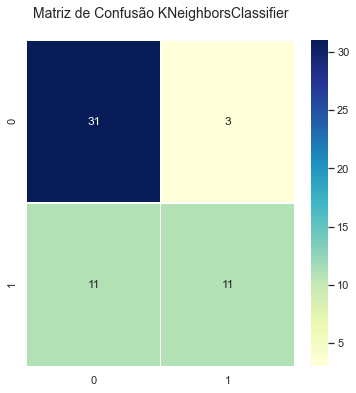

True Positives : 11
True Negatives : 31
Falso Positivos : 3
False Negative : 11


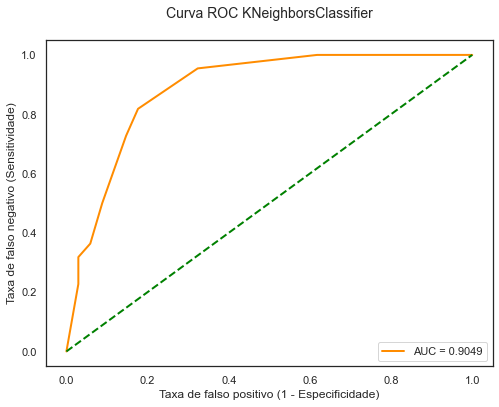

--------------------------------------------------
Métricas do modelo RandomForestClassifier

Acurácia: 0.7964
Precisão: 0.8547
Recall: 0.7182
F1-Score: 0.7499
Especificidade: 88.2353
Valor AUC: 0.8914


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        34
           1       0.78      0.64      0.70        22

    accuracy                           0.79        56
   macro avg       0.78      0.76      0.77        56
weighted avg       0.78      0.79      0.78        56



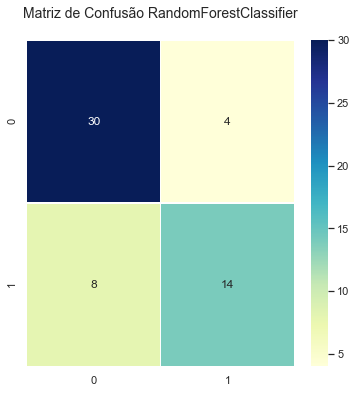

True Positives : 14
True Negatives : 30
Falso Positivos : 4
False Negative : 8


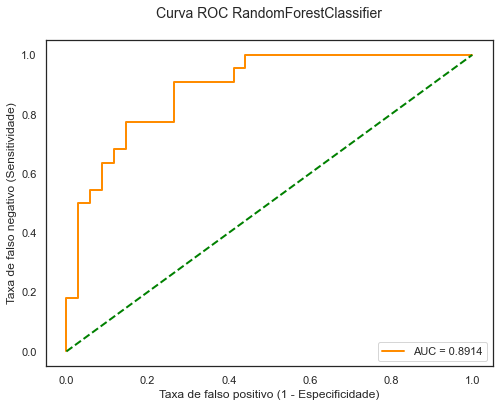

--------------------------------------------------
Métricas do modelo LogisticRegression

Acurácia: 0.8094
Precisão: 0.8282
Recall: 0.7755
F1-Score: 0.7838
Especificidade: 85.2941
Valor AUC: 0.8843


              precision    recall  f1-score   support

           0       0.85      0.85      0.85        34
           1       0.77      0.77      0.77        22

    accuracy                           0.82        56
   macro avg       0.81      0.81      0.81        56
weighted avg       0.82      0.82      0.82        56



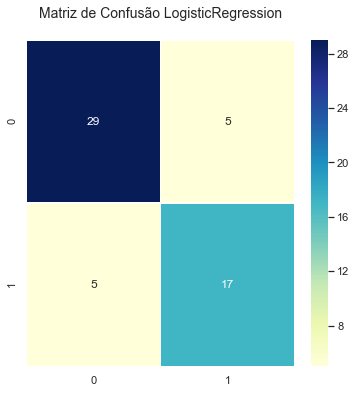

True Positives : 17
True Negatives : 29
Falso Positivos : 5
False Negative : 5


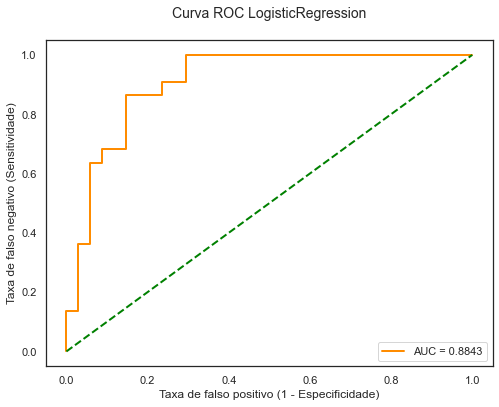

--------------------------------------------------
Métricas do modelo LogisticRegression

Acurácia: 0.8183
Precisão: 0.8343
Recall: 0.7845
F1-Score: 0.7953
Especificidade: 85.2941
Valor AUC: 0.8860


              precision    recall  f1-score   support

           0       0.83      0.85      0.84        34
           1       0.76      0.73      0.74        22

    accuracy                           0.80        56
   macro avg       0.80      0.79      0.79        56
weighted avg       0.80      0.80      0.80        56



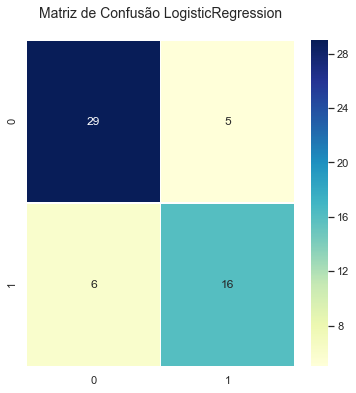

True Positives : 16
True Negatives : 29
Falso Positivos : 5
False Negative : 6


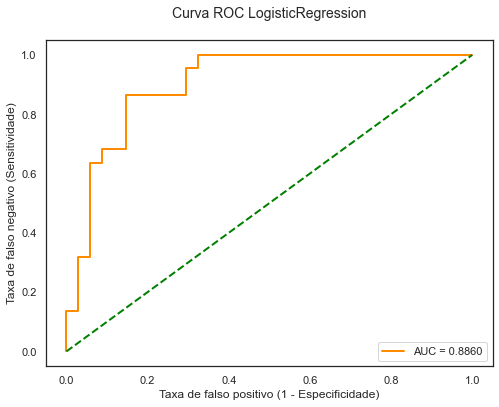

--------------------------------------------------
Métricas do modelo SVC

Acurácia: 0.8051
Precisão: 0.8179
Recall: 0.7645
F1-Score: 0.7800
Especificidade: 88.2353
Valor AUC: 0.8999


              precision    recall  f1-score   support

           0       0.77      0.88      0.82        34
           1       0.76      0.59      0.67        22

    accuracy                           0.77        56
   macro avg       0.77      0.74      0.74        56
weighted avg       0.77      0.77      0.76        56



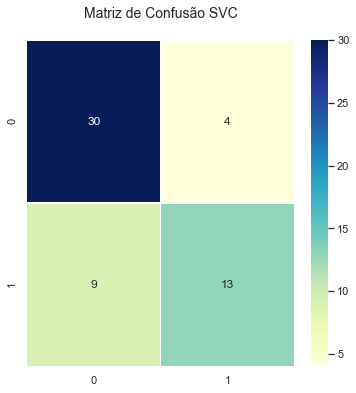

True Positives : 13
True Negatives : 30
Falso Positivos : 4
False Negative : 9


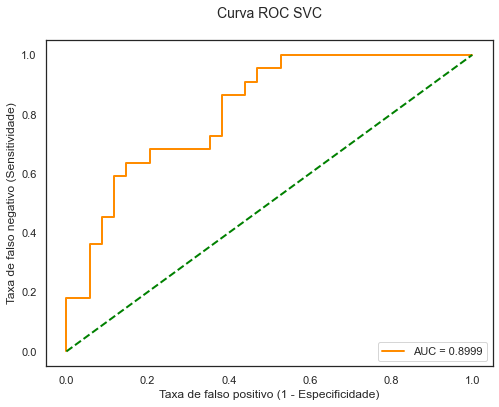

--------------------------------------------------
Métricas do modelo GradientBoostingClassifier

Acurácia: 0.7962
Precisão: 0.7961
Recall: 0.7745
F1-Score: 0.7741
Especificidade: 85.2941
Valor AUC: 0.8492


              precision    recall  f1-score   support

           0       0.83      0.85      0.84        34
           1       0.76      0.73      0.74        22

    accuracy                           0.80        56
   macro avg       0.80      0.79      0.79        56
weighted avg       0.80      0.80      0.80        56



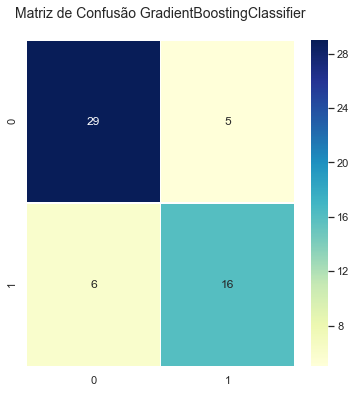

True Positives : 16
True Negatives : 29
Falso Positivos : 5
False Negative : 6


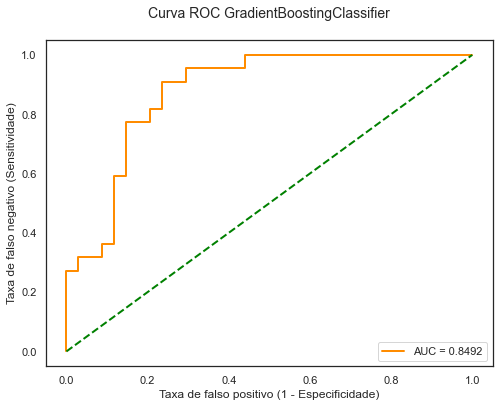

--------------------------------------------------


In [125]:
modelos = [knn,
           rfc,
           logreg_l1,
           logreg_l2,
           svm,
           gbm]

relatorio = {'Modelo':['KNN',
                       'Random Forest',
                       'Regressão Logistica L1',
                       'Regressão Logistica L2',
                       'SVM',
                       'Gradient Boost'],
             'Acurácia':[],
             'Precisão':[],
             'Recall':[],
             'F1-Score':[],
             'AUC':[],
             'Especificidade':[]
             }

for modelo in modelos:
    print("\033[1m" + f'Métricas do modelo {modelo.__class__.__name__}\n' + "\033[0m")
    Y_pred = modelo.predict(X_test)
    
    cv_acc = cross_val_score(modelo, X_train, y_train, scoring='accuracy', cv=10)
    cv_precisao = cross_val_score(modelo, X_train, y_train, scoring='precision', cv=10)
    cv_recall = cross_val_score(modelo, X_train, y_train, scoring='recall', cv=10)
    cv_f1 = cross_val_score(modelo, X_train, y_train, scoring='f1',cv=10)
    cv_auc = cross_val_score(modelo, X_train, y_train, scoring='roc_auc', cv=10)
    especificidade = confusion_matrix(y_test, Y_pred)[0][0] / (confusion_matrix(y_test, Y_pred)[0][0] +
                                                               confusion_matrix(y_test, Y_pred)[0][1]) * 100
    
    
    
    
    print(f"Acurácia: {cv_acc.mean():.4f}")
    print(f"Precisão: {cv_precisao.mean():.4f}")
    print(f"Recall: {cv_recall.mean():.4f}")
    print(f"F1-Score: {cv_f1.mean():.4f}")
    print(f"Especificidade: {especificidade:.4f}")
    print(f"Valor AUC: {cv_auc.mean():.4f}\n\n")


    print(classification_report(y_test, Y_pred))
    
    plt.rcParams['figure.figsize'] = (6, 6) 
    sns.heatmap(confusion_matrix(y_test, Y_pred), annot = True, linewidths=.5, cmap="YlGnBu")
    plt.title(f'Matriz de Confusão {modelo.__class__.__name__}\n',fontdict={'size':14})
    plt.show()
    
    print('True Positives : {}'.format(confusion_matrix(y_test, Y_pred)[1][1]))
    print('True Negatives : {}'.format(confusion_matrix(y_test, Y_pred)[0][0]))
    print('Falso Positivos : {}'.format(confusion_matrix(y_test, Y_pred)[0][1]))
    print('False Negative : {}'.format(confusion_matrix(y_test, Y_pred)[1][0]))
    
    y_pred_porcento = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_porcento)
    
    lw = 2
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 
             color='darkorange', 
             lw=lw, 
             label="AUC = %0.4f" % cv_auc.mean())
    plt.plot([0, 1], [0, 1], color='green', 
             lw=lw, linestyle='--')
    plt.xlabel('Taxa de falso positivo (1 - Especificidade)')
    plt.ylabel('Taxa de falso negativo (Sensitividade)')
    plt.title(f'Curva ROC {modelo.__class__.__name__}\n', fontdict={'size':14})
    plt.legend(loc="lower right")
    plt.show()
    
    relatorio['Acurácia'].append(cv_acc.mean())
    relatorio['Precisão'].append(cv_precisao.mean())
    relatorio['Recall'].append(cv_recall.mean())
    relatorio['F1-Score'].append(cv_f1.mean())
    relatorio['AUC'].append(cv_auc.mean())
    relatorio['Especificidade'].append(especificidade)

    print('-'*50)


    
    
relatorio = pd.DataFrame(relatorio).sort_values(by='Acurácia', ascending=False)
relatorio = relatorio.set_index('Modelo')

Tabela de scores:

In [126]:
relatorio.sort_values(by='Acurácia', ascending=False)

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
KNN,0.827809,0.888889,0.725455,0.787473,0.904924,91.176471
Regressão Logistica L2,0.818304,0.834293,0.784545,0.795308,0.885985,85.294118
Regressão Logistica L1,0.809411,0.828232,0.775455,0.783757,0.884318,85.294118
SVM,0.805101,0.817929,0.764545,0.780043,0.899924,88.235294
Random Forest,0.796367,0.854747,0.718182,0.749937,0.891364,88.235294
Gradient Boost,0.796207,0.796120,0.774545,0.774063,0.849242,85.294118


Até o momento, KNN foi o modelo que obteve melhor performance, possuindo:
- Maior valor de Especificidade (91.17)
- Maior acurácia (0.827)
- Maior precisão (0.888)
- Maior valor AUC (0.904)
- Segundo maior valor F1 (0.787), perdendo para Regressão Logística L2

Em segundo lugar, temos a Regressão Logística L2 que obteve:
- Segunda maior acurácia (0.818)
- Segunda maior Especificidade (85.29)
- Maior valor de F1-score (0.795)
- Maior valor de Recall (0.784)

**Melhor modelo:**

Apresentando maior valor de acurácia (0.827), precisão (0.888), AUC (0.904) e especificidade (91.17), além do segundo maior valor de F1-Score (0.787), o modelo KNN é o vencedor de nosso problema de Classificação.

# Analise SHAP

SHAP, ou SHapley Additive exPlanations, é um método descrito por Lundberg e Lee em 2016. Trata-se de uma ferramenta de explicabilidade de predição de modelos baseada em teoria de jogos utilizando valores SHapley (onde uma predição é explicada ao considerar cada feature do modelo como um "jogador"). 

Apesar de recente, SHAP está ganhando muito espaço em plataformas como Kaggle para desmistificar a ideia de que modelos de machine learning são "caixas-pretas".

Você pode ler mais sobre em https://christophm.github.io/interpretable-ml-book/shap.html

**SHAP KNN**

In [127]:
knn_explainer = shap.KernelExplainer(knn.predict,X_test)
knn_shap_values = knn_explainer.shap_values(X_test)

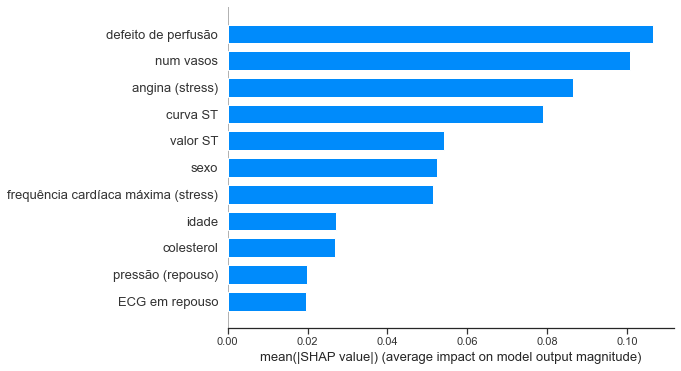

In [128]:
shap.summary_plot(knn_shap_values, X, plot_type="bar")

In [129]:
print("Três variaveis com maior valor SHAP medio (KNN):\n-defeito de perfusão\n-num vasos\n-angina (stress)")

Três variaveis com maior valor SHAP medio (KNN):
-defeito de perfusão
-num vasos
-angina (stress)


In [130]:
print("Três variaveis com menor valor SHAP medio (KNN):\n-ECG em repouso\n-pressão (repouso)\n-colesterol")

Três variaveis com menor valor SHAP medio (KNN):
-ECG em repouso
-pressão (repouso)
-colesterol


**SHAP Random Forest**

In [131]:
rfc_explainer = shap.KernelExplainer(rfc.predict,X_test)
rfc_shap_values = rfc_explainer.shap_values(X_test)

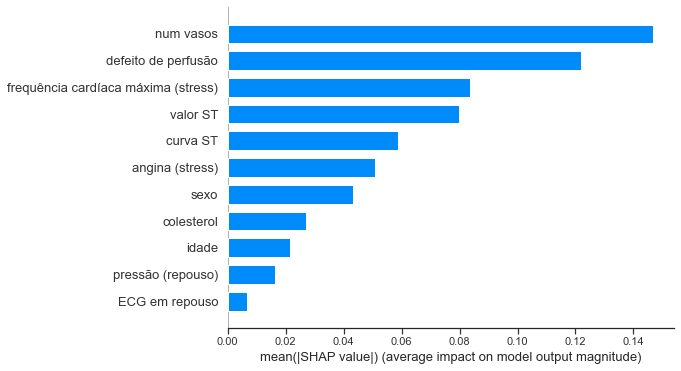

In [132]:
shap.summary_plot(rfc_shap_values, X, plot_type="bar")

In [133]:
print("Três variaveis com maior valor SHAP medio (Random Forest):\n-num vasos\n-defeito de perfusão\n-frequência cardiaca máxima (stress)")

Três variaveis com maior valor SHAP medio (Random Forest):
-num vasos
-defeito de perfusão
-frequência cardiaca máxima (stress)


In [134]:
print("Três variaveis com menor valor SHAP medio (Random Forest):\n-ECG em repouso\n-pressão (repouso)\n-idade")

Três variaveis com menor valor SHAP medio (Random Forest):
-ECG em repouso
-pressão (repouso)
-idade


**SHAP Regressão Logistica L1**

In [135]:
logregl1_explainer = shap.KernelExplainer(logreg_l1.predict,X_test)
logregl1_shap_values =  logregl1_explainer.shap_values(X_test)

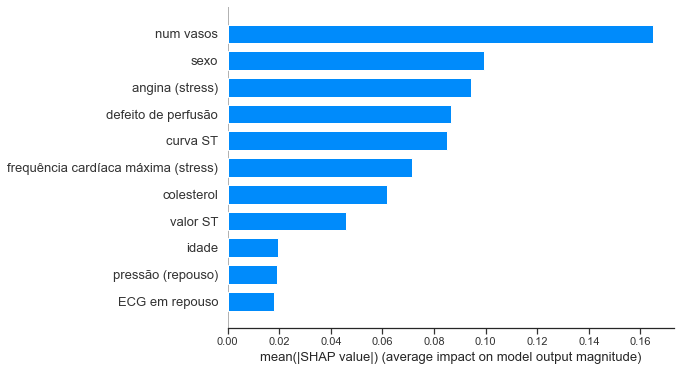

In [136]:
shap.summary_plot(logregl1_shap_values, X, plot_type="bar")

In [137]:
print("Três variaveis com maior valor SHAP medio (Regressão Logistica L1):\n-num vasos\n-sexo\n-angina (stress)")

Três variaveis com maior valor SHAP medio (Regressão Logistica L1):
-num vasos
-sexo
-angina (stress)


In [138]:
print("Três variaveis com menor valor SHAP medio (Regressão Logistica L1):\n-ECG em repouso\n-pressão (repouso)\n-idade")

Três variaveis com menor valor SHAP medio (Regressão Logistica L1):
-ECG em repouso
-pressão (repouso)
-idade


**SHAP Regressão Logistica L2**

In [139]:
logregl2_explainer = shap.KernelExplainer(logreg_l2.predict,X_test)
logregl2_shap_values =  logregl2_explainer.shap_values(X_test)

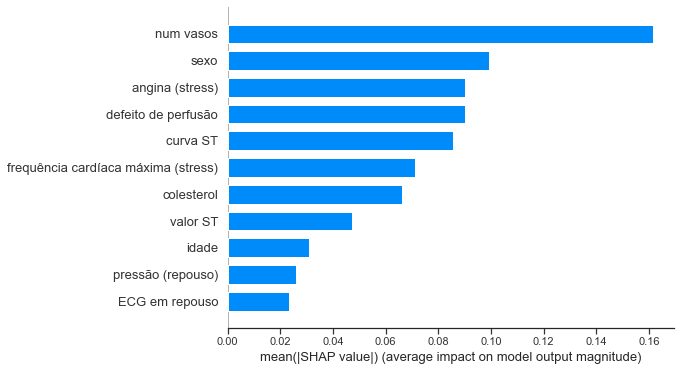

In [140]:
shap.summary_plot(logregl2_shap_values, X, plot_type="bar")

In [141]:
print("Três variaveis com maior valor SHAP medio (Regressão Logistica L2):\n-num vasos\n-sexo\n-angina (stress)")

Três variaveis com maior valor SHAP medio (Regressão Logistica L2):
-num vasos
-sexo
-angina (stress)


In [142]:
print("Três variaveis com menor valor SHAP medio (Regressão Logistica L2):\n-ECG em repouso\n-pressão (repouso)\n-idade")

Três variaveis com menor valor SHAP medio (Regressão Logistica L2):
-ECG em repouso
-pressão (repouso)
-idade


**SHAP SVM**

In [143]:
svm_explainer = shap.KernelExplainer(svm.predict,X_test)
svm_shap_values =  svm_explainer.shap_values(X_test)

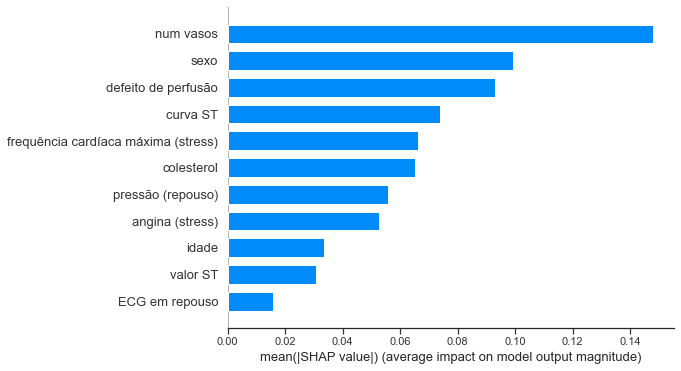

In [144]:
shap.summary_plot(svm_shap_values, X, plot_type="bar")

In [145]:
print("Três variaveis com maior valor SHAP medio (SVM):\n-num vasos\n-sexo\n-defeito de perfusão")

Três variaveis com maior valor SHAP medio (SVM):
-num vasos
-sexo
-defeito de perfusão


In [146]:
print("Três variaveis com menor valor SHAP medio (SVM):\n-ECG em repouso\n-valor ST\n-idade")

Três variaveis com menor valor SHAP medio (SVM):
-ECG em repouso
-valor ST
-idade


**SHAP Gradient Booost**

In [147]:
gbm_explainer = shap.KernelExplainer(gbm.predict,X_test)
gbm_shap_values = gbm_explainer.shap_values(X_test)

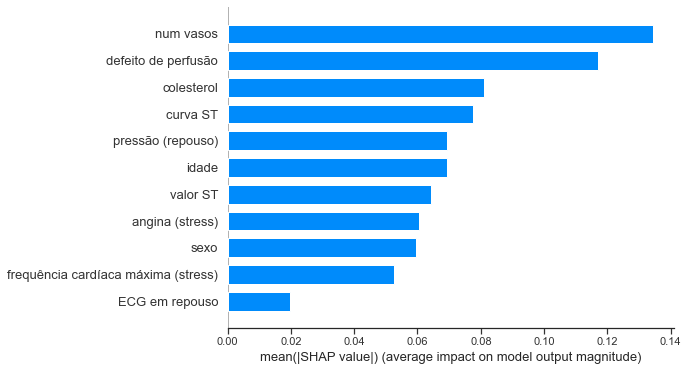

In [148]:
shap.summary_plot(gbm_shap_values, X, plot_type="bar")

In [149]:
print("Três variaveis com maior valor SHAP medio (Gradient Boost):\n-num vasos\n-defeito de perfusão\n-colesterol")

Três variaveis com maior valor SHAP medio (Gradient Boost):
-num vasos
-defeito de perfusão
-colesterol


Surpreendentemente, o modelo GBM valorizou muito a variável colesterol, sendo a terceira com maior valor SHAP médio. Nos modelos acima, colesterol recebeu um valor baixo, sendo o terceiro menor valor em KNN e quarto menor valor em Random Forest.

In [150]:
print("Três variaveis com menor valor SHAP medio (Gradient Boost):\n-ECG em repouso\n-frequencia cardíaca máxima (stress)\n-sexo")

Três variaveis com menor valor SHAP medio (Gradient Boost):
-ECG em repouso
-frequencia cardíaca máxima (stress)
-sexo


Algo parecido ocorre ao analisarmos os menores valores SHAP de GBM. Sexo e frequência cardiaca máxima (stress) obtiveram valores baixos aqui, mas medianos em KNN e frequência teve um valor alto em Random Forest.

Apesar de usarem penalidades diferentes, os modelos de regressão linear L1 e L2 são bastante parecidos, logo, era de se esperar resultados SHAP semelhantes.

Insights:

- **A variavel "num vasos" esteve entre os maiores valores SHAP em todos os modelos**

- A variavel "defeito de perfusão" esteve entre os maiores valores de quatro modelos (KNN, Random Forest, SVM e Gradient Boost)

- A variavel "angina (stress) esteve entre os maiores valores de três modelos (KNN, Regressão Logistica L1 e L2)

- A variavel "sexo" esteve entre os maiores valores dos modelos SVM, Regressões Logisticas L1 e L2, mas entre os menores valores de Gradient Boost

- A variavel "colesterol" esteve entre os maiores valores de Gradient Boost, mas obteve valores medianos ou baixos em outros modelos

- **A variavel "ECG em repouso" esteve entre os menores valores SHAP em todos os modelos**
- **A variavel "pressão (repouso)" esteve entre os menores valores SHAP de quatro modelos (KNN, Random Forest, Regressão Logistica L1 e L2)**
- A variavel "idade" esteve entre os menores valores SHAP de quatro modelos (Random Forest, SVM, Regressão Logistica L1 e L2)


# Modelos com redução de variaveis

Sabemos que obter variáveis na vida real pode ser um processo complicado. Sabendo quais são as variáveis mais importantes para nossos modelos, podemos focar nossos esforços na hora de obter mais dados. Aqui, vamos remover as três variáveis de menor valor SHAP de cada modelo, treiná-los e comparar os resultados.

**KNN pós-SHAP**:

Três variaveis com menor valor SHAP medio (KNN): 

ECG em repouso

pressão (repouso)

colesterol

In [151]:
knn_pos_shap = dados_para_modelo.drop(columns=['ECG em repouso','pressão (repouso)', 'colesterol'])

In [152]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(knn_pos_shap,Y,test_size = 0.2,random_state=42, shuffle = True)

In [153]:
params = {'n_neighbors':list(range(1, 101)),
          'weights':['uniform', 'distance'],
          'p':[1,2]}


In [154]:
knn_grid_cv_shap = KNeighborsClassifier()
knn_grid_cv_shap = GridSearchCV(knn_grid_cv_shap, param_grid=params, cv=5) 
knn_grid_cv_shap.fit(X_train_knn, y_train_knn)
print("Melhores hiperparâmetros pós-analise SHAP:",knn_grid_cv.best_params_)

Melhores hiperparâmetros pós-analise SHAP: {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [155]:
knn_shap = KNeighborsClassifier(n_neighbors = 8,
                           p=1,
                           weights = 'uniform')

knn_shap.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=1,
                     weights='uniform')

**Random Forest pós-SHAP**:

Três variaveis com menor valor SHAP medio (Random Forest):

-ECG em repouso

-pressão (repouso)

-idade

In [156]:
rfc_pos_shap = dados_para_modelo.drop(columns=['ECG em repouso','pressão (repouso)', 'idade'])

In [157]:
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(rfc_pos_shap,Y,test_size = 0.2,random_state=42, shuffle = True)

In [158]:
params = { 
    'n_estimators': list(np.arange(5,155,5)),
    'max_depth' : list(np.arange(1,11,1)),
    'criterion' : ['entropy','gini']
}


In [159]:
rfc_gridcv_shap = RandomForestClassifier(random_state=42)
rfc_gridcv_shap = GridSearchCV(estimator=rfc_gridcv_shap, param_grid=params, cv= 5)
rfc_gridcv_shap.fit(X_train_rfc, y_train_rfc)
print("Melhores hiperparâmetros pós-analise SHAP:", rfc_gridcv_shap.best_params_)

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Melhores hiperparâmetros pós-analise SHAP: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 140}


In [160]:
rfc_shap = RandomForestClassifier(random_state=42,
                             n_estimators=140,
                             max_depth= 6,
                             criterion = 'entropy')

rfc_shap.fit(X_train_rfc, y_train_rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Regressão Logistica L1 e L2 pós-SHAP**:

Três variaveis com menor valor SHAP medio (Regressão Logistica L1 e L2):

-ECG em repouso

-pressão (repouso)

-idade

**L1:**

In [161]:
logreg_pos_shap = dados_para_modelo.drop(columns=['ECG em repouso','pressão (repouso)', 'idade'])

In [162]:
X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(logreg_pos_shap,Y,test_size = 0.2,random_state=42, shuffle = True)

In [163]:
params_l1 = { 
    'C' :  np.logspace(0, 4, 10),
    'solver' : ['liblinear', 'saga']
}

In [164]:
logreg_l1_gridcv_shap = LogisticRegression(penalty = 'l1', max_iter=10000)
logreg_l1_gridcv_shap = GridSearchCV(estimator=logreg_l1_gridcv_shap, param_grid=params_l1, cv= 5)
logreg_l1_gridcv_shap.fit(X_train_logreg, y_train_logreg)
print("Melhores hiperparâmetros:",logreg_l1_gridcv_shap.best_params_)

Melhores hiperparâmetros: {'C': 1.0, 'solver': 'liblinear'}


In [165]:
logreg_l1_shap = LogisticRegression(penalty = 'l1',
                               C = 1,
                               solver = 'liblinear',
                               max_iter=2000,
                               random_state=42)

logreg_l1_shap.fit(X_train_logreg, y_train_logreg)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

**L2**:

In [166]:
params_l2 = { 
    'C' :  np.logspace(0, 4, 10),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


In [167]:
logreg_l2_gridcv_shap = LogisticRegression(penalty = 'l2', max_iter=2000)
logreg_l2_gridcv_shap = GridSearchCV(estimator=logreg_l2_gridcv_shap, param_grid=params_l2, cv= 5)
logreg_l2_gridcv_shap.fit(X_train_logreg, y_train_logreg)
print("Melhores hiperparâmetros:",logreg_l2_gridcv_shap.best_params_)

Melhores hiperparâmetros: {'C': 7.742636826811269, 'solver': 'newton-cg'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [168]:
logreg_l2_shap = LogisticRegression(penalty = 'l2',
                               C = 7.742636826811269,
                               solver = 'newton-cg',
                               random_state=42)

logreg_l2_shap.fit(X_train_logreg, y_train_logreg)

LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

**SVM pós-SHAP**:

Três variaveis com menor valor SHAP medio (SVM):

-ECG em repouso

-valor ST

-idade

In [169]:
svm_pos_shap = dados_para_modelo.drop(columns=['ECG em repouso','valor ST', 'idade'])

In [170]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(svm_pos_shap,Y,test_size = 0.2,random_state=42, shuffle = True)

In [171]:
params_svm = [{'C': [0.1,1, 10, 100, 1000],
               'gamma': [1,0.1,0.01,0.001],
               'kernel': ['rbf', 'poly', 'sigmoid','linear']}]

In [172]:
svm_gridcv_shap = SVC(random_state=42)
svm_gridcv_shap = GridSearchCV(estimator=svm_gridcv_shap, param_grid=params_svm, cv= 5)
svm_gridcv_shap.fit(X_train_svm, y_train_svm)
print("Best hiperparâmeters:\n",svm_gridcv_shap.best_params_)

Best hiperparâmeters:
 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [173]:
svm_shap = SVC(C=100,
          gamma=0.001,
          kernel='rbf',
          random_state=42,
          probability=True)

svm_shap.fit(X_train_svm, y_train_svm)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

**Gradient Boost pós-SHAP**:

Três variaveis com menor valor SHAP medio (Gradient Boost):

-ECG em repouso

-frequencia cardíaca máxima (stress)

-sexo


In [174]:
gbm_pos_shap = dados_para_modelo.drop(columns=['ECG em repouso','frequência cardíaca máxima (stress)', 'sexo'])

In [175]:
X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(gbm_pos_shap,Y,test_size = 0.2,random_state=42, shuffle = True)

In [176]:
params = { 
    'learning_rate': [0.05, 0.1 , 0.15],
    'n_estimators':[50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150],
    'max_depth' : [2, 3, 4, 5],
    'min_samples_split':[2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf':[1,3,5,7]}

In [177]:
gbm_gridcv_shap = GradientBoostingClassifier(random_state=42)
gbm_gridcv_shap = GridSearchCV(estimator=gbm_gridcv_shap, param_grid=params, cv= 5)
gbm_gridcv_shap.fit(X_train_gbm, y_train_gbm)
print("Melhores hiperparâmetros:", gbm_gridcv_shap.best_params_)

Melhores hiperparâmetros: {'learning_rate': 0.15, 'max_depth': 3, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 90}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [178]:
gbm_shap = GradientBoostingClassifier(random_state=42,
                             n_estimators=90,
                             max_depth= 3,
                             learning_rate=0.15,
                             min_samples_leaf=7,
                             min_samples_split=2)

gbm_shap.fit(X_train_gbm, y_train_gbm)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.15, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=7, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Scores:

In [179]:
modelos_shap = [knn_shap,
           rfc_shap,
           logreg_l1_shap,
           logreg_l2_shap,
           svm_shap,
           gbm_shap]

relatorio_pos_shap = {'Modelo':['KNN pós-SHAP',
                       'Random Forest pós-SHAP',
                       'Regressão Logistica L1 pós-SHAP',
                       'Regressão Logistica L2 pós-SHAP',
                       'SVM pós-SHAP',
                       'Gradient Boost pós-SHAP'],
             'Acurácia':[],
             'Precisão':[],
             'Recall':[],
             'F1-Score':[],
             'AUC':[],
             'Especificidade':[]
             }

for modelo in modelos_shap:
    print("\033[1m" + f'Métricas do modelo {modelo.__class__.__name__} pós remoção de features\n' + "\033[0m")
    
    if modelo.__class__.__name__ == 'KNeighborsClassifier':
        X_train, X_test, y_train, y_test  = X_train_knn, X_test_knn, y_train_knn, y_test_knn 
    elif modelo.__class__.__name__ == 'RandomForestClassifier':
        X_train, X_test, y_train, y_test  = X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc 
    elif modelo.__class__.__name__ == 'LogisticRegression':
        X_train, X_test, y_train, y_test  = X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg
    elif modelo.__class__.__name__ == 'SVC':
        X_train, X_test, y_train, y_test = X_train_svm, X_test_svm, y_train_svm, y_test_svm
    elif modelo.__class__.__name__ == 'GradientBoostingClassifier':
        X_train, X_test, y_train, y_test = X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm
        
    Y_pred = modelo.predict(X_test)
    
    cv_acc = cross_val_score(modelo, X_train, y_train, scoring='accuracy', cv=10)
    cv_precisao = cross_val_score(modelo, X_train, y_train, scoring='precision', cv=10)
    cv_recall = cross_val_score(modelo, X_train, y_train, scoring='recall', cv=10)
    cv_f1 = cross_val_score(modelo, X_train, y_train, scoring='f1',cv=10)
    cv_auc = cross_val_score(modelo, X_train, y_train, scoring='roc_auc', cv=10)
    especificidade = confusion_matrix(y_test, Y_pred)[0][0] / (confusion_matrix(y_test, Y_pred)[0][0] +
                                                               confusion_matrix(y_test, Y_pred)[0][1]) * 100
    
    
    
    
    print(f"Acurácia: {cv_acc.mean():.4f}")
    print(f"Precisão: {cv_precisao.mean():.4f}")
    print(f"Recall: {cv_recall.mean():.4f}")
    print(f"F1-Score: {cv_f1.mean():.4f}")
    print(f"Especificidade: {especificidade:.4f}")
    print(f"Valor AUC: {cv_auc.mean():.4f}")
    
    relatorio_pos_shap['Acurácia'].append(cv_acc.mean())
    relatorio_pos_shap['Precisão'].append(cv_precisao.mean())
    relatorio_pos_shap['Recall'].append(cv_recall.mean())
    relatorio_pos_shap['F1-Score'].append(cv_f1.mean())
    relatorio_pos_shap['AUC'].append(cv_auc.mean())
    relatorio_pos_shap['Especificidade'].append(especificidade)

    print('-'*50)


    
    
relatorio_pos_shap = pd.DataFrame(relatorio_pos_shap).sort_values(by='Acurácia', ascending=False)

Métricas do modelo KNeighborsClassifier pós remoção de features

Acurácia: 0.8010
Precisão: 0.8634
Recall: 0.7164
F1-Score: 0.7646
Especificidade: 94.1176
Valor AUC: 0.8956
--------------------------------------------------
Métricas do modelo RandomForestClassifier pós remoção de features

Acurácia: 0.7921
Precisão: 0.8367
Recall: 0.7173
F1-Score: 0.7500
Especificidade: 91.1765
Valor AUC: 0.8706
--------------------------------------------------
Métricas do modelo LogisticRegression pós remoção de features

Acurácia: 0.8187
Precisão: 0.8377
Recall: 0.7845
F1-Score: 0.7975
Especificidade: 85.2941
Valor AUC: 0.8918
--------------------------------------------------
Métricas do modelo LogisticRegression pós remoção de features

Acurácia: 0.8098
Precisão: 0.8267
Recall: 0.7655
F1-Score: 0.7824
Especificidade: 85.2941
Valor AUC: 0.8925
--------------------------------------------------
Métricas do modelo SVC pós remoção de features

Acurácia: 0.8229
Precisão: 0.8310
Recall: 0.8036
F1-Score:

In [180]:
relatorio = relatorio.reset_index()
relatorios = [relatorio,relatorio_pos_shap]
resultados_full = pd.concat(relatorios)
resultados_full = resultados_full.set_index('Modelo')


Tabela de Scores:

In [181]:
resultados_full = resultados_full.reindex(index = ['KNN',
                                                   'KNN pós-SHAP',
                                                   'Random Forest',
                                                   'Random Forest pós-SHAP',
                                                   'Regressão Logistica L1',
                                                   'Regressão Logistica L1 pós-SHAP',
                                                   'Regressão Logistica L2',
                                                   'Regressão Logistica L2 pós-SHAP',
                                                   'SVM',
                                                   'SVM pós-SHAP',
                                                   'Gradient Boost',
                                                   'Gradient Boost pós-SHAP'])

resultados_full

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
KNN,0.827809,0.888889,0.725455,0.787473,0.904924,91.176471
KNN pós-SHAP,0.800950,0.863442,0.716364,0.764580,0.895568,94.117647
Random Forest,0.796367,0.854747,0.718182,0.749937,0.891364,88.235294
Random Forest pós-SHAP,0.792057,0.836667,0.717273,0.750013,0.870606,91.176471
Regressão Logistica L1,0.809411,0.828232,0.775455,0.783757,0.884318,85.294118
Regressão Logistica L1 pós-SHAP,0.818737,0.837700,0.784545,0.797459,0.891818,85.294118
Regressão Logistica L2,0.818304,0.834293,0.784545,0.795308,0.885985,85.294118
Regressão Logistica L2 pós-SHAP,0.809844,0.826724,0.765455,0.782407,0.892500,85.294118
SVM,0.805101,0.817929,0.764545,0.780043,0.899924,88.235294


**KNN pré e pós remoção de features**

In [182]:
resultados_full[(resultados_full.index == 'KNN') | (resultados_full.index == 'KNN pós-SHAP')]

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
KNN,0.827809,0.888889,0.725455,0.787473,0.904924,91.176471
KNN pós-SHAP,0.800950,0.863442,0.716364,0.764580,0.895568,94.117647


O modelo KNN pós remoção de features perdeu aproximadamente:

- 0.026 de acurácia (acc final: 0.80)
- 0.025 de precisão (precisão final: 0.863)
- 0.009 de Recall (recall final: 0.716)
- 0.022 de F1-Score (F1-Score final: 0.764)
- 0.009 de AUC (AUC final: 0.895)

E ganhou aproximadamente:
- 0.029 (2.94) de especificidade (especificidade final: 94.11)


Os resultados aqui são abertos a interpretação, mas considero um resultado positivo. Apesar de apresentarmos baixa na maioria das métricas, obtivemos um ganho de aproximadamente 3 pontos em Especificidade (uma das metricas mais valorizadas para nosso problema de classificação), alcançando 94.117, a maior Especificidade entre todos os modelos, potencialmente diminuindo nossos falso negativos. A diminuição de Recall e AUC foram bem pequenas (menores que 0.01). A diminuição de 0.025 para métrica precisão pode se provar um futuro problema.

Considero que para o modelo KNN, a remoção de features possuiu um impacto positivo no rendimento do modelo.

**Random Forest pré e pós remoção de features**

In [183]:
resultados_full[(resultados_full.index == 'Random Forest') | (resultados_full.index == 'Random Forest pós-SHAP')]

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
Random Forest,0.796367,0.854747,0.718182,0.749937,0.891364,88.235294
Random Forest pós-SHAP,0.792057,0.836667,0.717273,0.750013,0.870606,91.176471


O modelo Random Forest pós remoção de features perdeu aproximadamente:

- 0.004 de acurácia (acc final: 0.792)

- 0.018 de precisão (precisão final: 0.836667)

- 0.0009 de Recall (recall final: 0.717)

- 0.02 de AUC (AUC final: 0.87)

E ganhou aproximadamente:

- 0.001 de F1-Score (F1-Score final: 0.750)

- 0.029 (2.94) de especificidade (especificidade final: 91.17)


Temos diferenças extremamente baixas em acurácia, Recall e F1-Score (menores que 0.01), e perdas relativamente baixas em precisão e AUC (0.018 e 0.02 respectivamente) com um trade-off positivo para Especificidade (apróx. 3 pontos). 

Novamente, considero que o ganho consideravel de especificidade justifica a leve diminuiçao das outras métricas.

**Regressão Logistica L1 pré e pós remoção de features**

In [184]:
resultados_full[(resultados_full.index == 'Regressão Logistica L1') | (resultados_full.index == 'Regressão Logistica L1 pós-SHAP')]

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
Regressão Logistica L1,0.809411,0.828232,0.775455,0.783757,0.884318,85.294118
Regressão Logistica L1 pós-SHAP,0.818737,0.837700,0.784545,0.797459,0.891818,85.294118


O modelo Regressão Logistica L1 pós remoção de features ganhou aproximadamente:

- 0.009 de acurácia (acc final: 0.818)

- 0.009 de precisão (precisão final: 0.837)

- 0.009 de Recall (recall final: 0.784)

- 0.013 de F1-Score (F1-Score final: 0.797)

- 0.007 de AUC (AUC final: 0.891)

e não demonstrou diferença em Especificidade:

- Especificidade final: 85.29

Na Regressão Logistica com penalidade Lasso (L1), observamos uma melhoria em todas as métricas além de Especificidade (que se manteve inalterada). Apesar de não estar entre os resultados mais favoraveis se comparado aos outros modelos (4 das 5 métricas favorecidas apresentaram um aumento menor que 0.01), seu aumento de rendimento via diminuição de features o torna um modelo interessante para estudos posteriores. É possivel que, com uma quantidade maior de dados, estes ganhos de valor se tornem mais robustos.

**Regressão Logistica L2 pré e pós remoção de features**

In [185]:
resultados_full[(resultados_full.index == 'Regressão Logistica L2') | (resultados_full.index == 'Regressão Logistica L2 pós-SHAP')]

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
Regressão Logistica L2,0.818304,0.834293,0.784545,0.795308,0.885985,85.294118
Regressão Logistica L2 pós-SHAP,0.809844,0.826724,0.765455,0.782407,0.892500,85.294118


O modelo de Regressão Logistica penalidade Ridge pós remoção de features perdeu aproximadamente:

- 0.008 de acurácia (acc final: 0.809)

- 0.007 de precisão (precisão final: 0.826)

- 0.019 de Recall (recall final: 0.765)

- 0.012 de F1-Score (F1-Score final: 0.782)

ganhou aproximadamente:

- 0.006 de AUC (AUC final: 0.892)

e não demonstrou diferença em Especificidade:

- Especificidade final: 85.29

Diferente da penalidade Lasso, a penalidade Ridge apresentou quedas em quase todas as métricas, sendo as perdas em acurácia e precisão valores baixos (abaixo de 0.01). AUC cresceu em uma escala muito baixa (0.006) enquanto Especificidade não sofreu alteração (como aconteceu em L1).

Apesar de duas métricas terem perdido valores abaixo de 0.01, analisando os resultados podemos afirmar que a remoção de features não foi vantajosa para o modelo LogReg L2 (visto que o unico ganho, AUC, tambem teve valor menor que 0.01).

**SVM pré e pós remoção de features**

In [186]:
resultados_full[(resultados_full.index == 'SVM') | (resultados_full.index == 'SVM pós-SHAP')]

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
SVM,0.805101,0.817929,0.764545,0.780043,0.899924,88.235294
SVM pós-SHAP,0.822868,0.831033,0.803636,0.805558,0.899318,85.294118


O modelo SVM pós remoção de features perdeu aproximadamente:

- 0.029 (2.94) de Especificidade (Especificidade final: 85.29)

- 0.0006 de AUC (AUC final: 0.899)

e ganhou aproximadamente:

- 0.017 de acurácia (acc final: 0.822)

- 0.013 de precisão (precisão final: 0.831)

- 0.039 de Recall (recall final: 0.803)

- 0.025 de F1-Score (F1-Score final: 0.805)

Com SVM, era de se esperar observar um aumento na maioria das métricas, visto que é um modelo famoso por performar bem com pouca quantidade de dados. Houve uma baixa extremamente pequena em AUC (0.0006) e uma baixa consideravel em Especificidade. Apesar do aumento em acurácia, precisão, recall e F1-Score, para o problema de nosso notebook, o uso do SVM não seria aconselhado, já que especificidade é uma das métricas que decidimos priorizar.

Contudo, podemos teorizar que até o momento, SVM é o modelo que melhor reagiu a diminuição de features, com ganhos constantes e estatisticamente relevantes. 

**Gradient Boost pré e pós remoção de features**

In [187]:
resultados_full[(resultados_full.index == 'Gradient Boost') | (resultados_full.index == 'Gradient Boost pós-SHAP')]

,Acurácia,Precisão,Recall,F1-Score,AUC,Especificidade
Modelo,,,,,,
Gradient Boost,0.796207,0.796120,0.774545,0.774063,0.849242,85.294118
Gradient Boost pós-SHAP,0.764173,0.765573,0.724545,0.727530,0.867424,85.294118


O modelo Gradient Boost pós remoção de features perdeu aproximadamente:

- 0.032 de acurácia (acc final: 0.764)

- 0.03 de precisão (precisão final: 0.765)

- 0.05 de Recall (recall final: 0.724)

- 0.046 de F1-Score (F1-Score final: 0.727)

ganhou aproximadamente:

- 0.018 de AUC (AUC final: 0.867)

e não demonstrou diferença em Especificidade:

- Especificidade final: 85.29

Gradient Boost (ou GBM) foi possivelmente o modelo mais impactado negativamente pela remoção de features. Tivemos perdas em 4 métricas, assim como em Random Forest, Regressão Logistica L2 e KNN (que perdeu valores em 5 métricas), porém, diferente dos modelos aqui citados, os valores perdidos em GBM foram todos mais altos que 0.01, enquanto seu ganho foi relativamente baixo (0.018 em AUC) e sua especificidade não mudou. Considerando estes valores, podemos concluir que a remoção de features não contribuiu positivamente para o modelo.

# Conclusão:

Cada modelo reagiu de uma forma a remoção de features: KNN e Random Forest sacrificaram pequenos valores em suas métricas em prol de Especificidade. Regressão Logistica L1 (Lasso) teve uma melhora em quase todas suas métricas, enquanto a Regressão Logistica L2 (Ridge) apresentou piora em quase todas as suas.

SVM sacrificou especificidade por um aumento em acurácia, precisão, recall e F1, o que, dependendo do problema a ser resolvido, pode ser considerado um case de sucesso (infelizmente não para nossa classificação, já que decidimos priorizar especificidade). Gradient Boost sofreu baixas consideraveis em troca de um leve aumento em AUC.

Grande parte dessa variação de valores (seja para ganho ou perda) foi bastante baixo (abaixo de 0.01), o que por si só já pode ser considerado uma vitoria. Mesmo removendo três features (quase 30% de todo o dataset), obtivemos resultados relativamente parecidos com os modelos "completos". Na vida real, isso implica em um aumento de produtividade e rendimento, visto que podemos chegar a "mesma" conclusão com menos dados e menos processamento/poder computacional. 

É importante tentar entender o que está acontecendo com nosso dataset e com o que a análise SHAP quer nos dizer. Por exemplo: a variavel "ECG em repouso" esteve entre os menores valores SHAP entre todos os modelos (consequentemente foi removida em todos os casos). Isto não deveria ser uma novidade completa para nós, pois na análise exploratoria de dados fomos capazes de obter essa intuição sobre a váriavel. O bom senso sempre deve prevalecer ao remover uma feature.

Tambem é importante deixar claro que esta experiencia foi feita com um dataset relativamente pequeno para os padrões atuais. Nossos modelos performariam igualmente bem (ou mal) com um dataset mais robusto? A diminuição de features aumentariam a escala de ganhos e perdas de métricas? São perguntas a serem respondidas.

Existe tambem a discussão sobre o tempo de aplicação do modelo, que, com menos features, provavelmente apresentará um timedelta menor em seus fits e gridsearchs, porém devido a pouca quantidade de dados, a aplicação desta metrica nesse estudo seria irrelevante.

Para nosso proposito, a remoção de features tornou nossos modelos de KNN e Random Forest mais interessantes devido ao aumento de especificidade, mas fica claro que os modelos mais beneficiados por esta ação foram a **Regressão Logistica L1 (Lasso) e SVM**.

Ao compararmos todos os modelos, nosso vencedores são KNN (segunda maior Especificidade, maior Acurácia, maior Precisão e maior valor AUC) e KNN pós-SHAP (maior Especificidade e segunda maior Precisão)


Parabens KNN! Aqui está seu bolo.

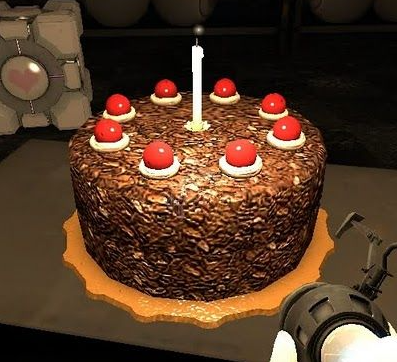